# Time Series Analysis August Complex Thapa Polys Only

In [2]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import statsmodels.api as sm
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from shapely.validation import explain_validity


warnings.filterwarnings('ignore')
import seaborn as sns
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

## Load per overpass polygons and generate daily polygons
only need to do once for each fire

In [2]:
# load in the PER OVERPASS polygons and attributes
fire_polygons = gpd.read_file('august_complex_polygons_only_VIIRS_overpass.geojson') #polygons only
fire_attributes = pd.read_csv('august_complex_polygons_attributes_VIIRS_overpass.csv') #other fire attributes
fire_attributes['Fire Name'] = fire_attributes['Fire Name'].str.upper() #make all fire names all caps
aug_complex_inds = np.where(fire_attributes['Fire Name']=='AUGUST COMPLEX')[0];
print(type(aug_complex_inds))

ac_thapa_att = fire_attributes.iloc[aug_complex_inds]

datestrings = [ac_thapa_att['Current Day'].iloc[i]+ ' '+\
               str(int(ac_thapa_att['Current Overpass'].iloc[i])).zfill(4) for i in range(len(ac_thapa_att))]

ac_thapa_poly = fire_polygons.iloc[aug_complex_inds]
ac_thapa = gpd.GeoDataFrame(pd.concat([ac_thapa_att[['Fire Name', 'Current Day', 'Number of NEW VIIRS points','NEW FRP']],\
                                       pd.DataFrame({'DateTim':datestrings}), ac_thapa_poly], axis=1))
ac_thapa

<class 'numpy.ndarray'>


,Fire Name,Current Day,Number of NEW VIIRS points,NEW FRP,DateTim,geometry
0,AUGUST COMPLEX,2020-08-18,0.0,0.00,2020-08-18 0800,"POLYGON ((-122.80713 39.65944, -122.80713 39.6..."
1,AUGUST COMPLEX,2020-08-18,8.0,21.33,2020-08-18 0854,"MULTIPOLYGON (((-122.74336 39.59618, -122.7433..."
2,AUGUST COMPLEX,2020-08-18,40.0,79.30,2020-08-18 0948,"MULTIPOLYGON (((-122.73571 39.59572, -122.7357..."
3,AUGUST COMPLEX,2020-08-18,11.0,33.49,2020-08-18 1036,"MULTIPOLYGON (((-122.76537 39.69055, -122.7653..."
4,AUGUST COMPLEX,2020-08-18,44.0,1885.55,2020-08-18 2018,"MULTIPOLYGON (((-122.68585 39.75122, -122.6858..."
...,...,...,...,...,...,...
376,AUGUST COMPLEX,2020-10-30,1.0,5.40,2020-10-30 2142,"POLYGON ((-123.31461 40.28574, -123.31458 40.2..."
377,AUGUST COMPLEX,2020-11-01,1.0,1.48,2020-11-01 1030,"POLYGON ((-122.89645 39.88422, -122.89646 39.8..."
378,AUGUST COMPLEX,2020-11-03,2.0,4.40,2020-11-03 0900,None
379,AUGUST COMPLEX,2020-11-03,2.0,4.81,2020-11-03 0954,"MULTIPOLYGON (((-123.30926 40.33792, -123.3092..."


In [3]:
print(np.where(ac_thapa['geometry']==None)[0])
ac_thapa = ac_thapa.drop(np.where(ac_thapa['geometry']==None)[0])

[ 38 316 318 327 362 364 368 369 370 374 375 378]


In [4]:
tic = np.datetime64('now')
ac_thapa_daily = ac_thapa.dissolve(by='Current Day', aggfunc='max',as_index=False)
ac_thapa_daily
toc = np.datetime64('now')
print(toc-tic)

534 seconds


In [5]:
#save the daily polygons

hi = ac_thapa_daily['geometry']
hi
therest = ac_thapa_daily[['Fire Name','Current Day','Number of NEW VIIRS points', 'NEW FRP', 'DateTim']]
therest

hi.to_file("august_complex_polygons_only_VIIRS_daily.geojson", driver='GeoJSON')
therest.to_csv('august_complex_polygons_attributes_VIIRS_daily.csv')

## Load in daily polygons

In [3]:
# load in the daily polygons and attributes
fire_polygons = gpd.read_file('holiday_farm_polygons_only_VIIRS_daily.geojson') #polygons only
fire_attributes = pd.read_csv('holiday_farm_polygons_attributes_VIIRS_daily.csv') #other fire attributes
fire_attributes['Fire Name'] = fire_attributes['Fire Name'].str.upper() #make all fire names all caps
aug_complex_inds = np.where(fire_attributes['Fire Name']=='HOLIDAY FARM')[0];
#print(type(aug_complex_inds))

ac_thapa_att = fire_attributes.iloc[aug_complex_inds]


ac_thapa_poly = fire_polygons.iloc[aug_complex_inds]
ac_thapa_daily = gpd.GeoDataFrame(pd.concat([ac_thapa_att[['Fire Name', 'Current Day','Number of NEW VIIRS points','NEW FRP', 'DateTim']],\
                                 ac_thapa_poly], axis=1))
ac_thapa_daily

,Fire Name,Current Day,Number of NEW VIIRS points,NEW FRP,DateTim,geometry
0,HOLIDAY FARM,2020-09-09,685.0,31827.80,2020-09-09 2148,"MULTIPOLYGON (((-122.32336 44.11331, -122.3233..."
1,HOLIDAY FARM,2020-09-10,1336.0,12870.43,2020-09-10 2130,"MULTIPOLYGON (((-122.71246 44.07094, -122.7125..."
2,HOLIDAY FARM,2020-09-11,437.0,3247.69,2020-09-11 2200,"MULTIPOLYGON (((-122.28105 44.05728, -122.2811..."
3,HOLIDAY FARM,2020-09-12,318.0,2346.27,2020-09-12 2142,"MULTIPOLYGON (((-122.27995 44.07382, -122.2798..."
4,HOLIDAY FARM,2020-09-13,242.0,1501.90,2020-09-13 2212,"MULTIPOLYGON (((-122.27475 44.10098, -122.2747..."
5,HOLIDAY FARM,2020-09-14,91.0,1286.90,2020-09-14 2154,"MULTIPOLYGON (((-122.30905 44.04850, -122.3091..."
6,HOLIDAY FARM,2020-09-15,171.0,920.70,2020-09-15 2136,"MULTIPOLYGON (((-122.29276 44.05283, -122.2927..."
7,HOLIDAY FARM,2020-09-16,120.0,3999.50,2020-09-16 2206,"MULTIPOLYGON (((-122.38154 44.03674, -122.3815..."
8,HOLIDAY FARM,2020-09-17,114.0,1431.05,2020-09-17 2148,"MULTIPOLYGON (((-122.31535 44.04162, -122.3154..."
9,HOLIDAY FARM,2020-09-18,6.0,8.85,2020-09-18 0912,"MULTIPOLYGON (((-122.27118 44.09146, -122.2712..."


## New Version of plot all polygons (4/1/2022)
More red is later on, uses the per overpass version of my polygons


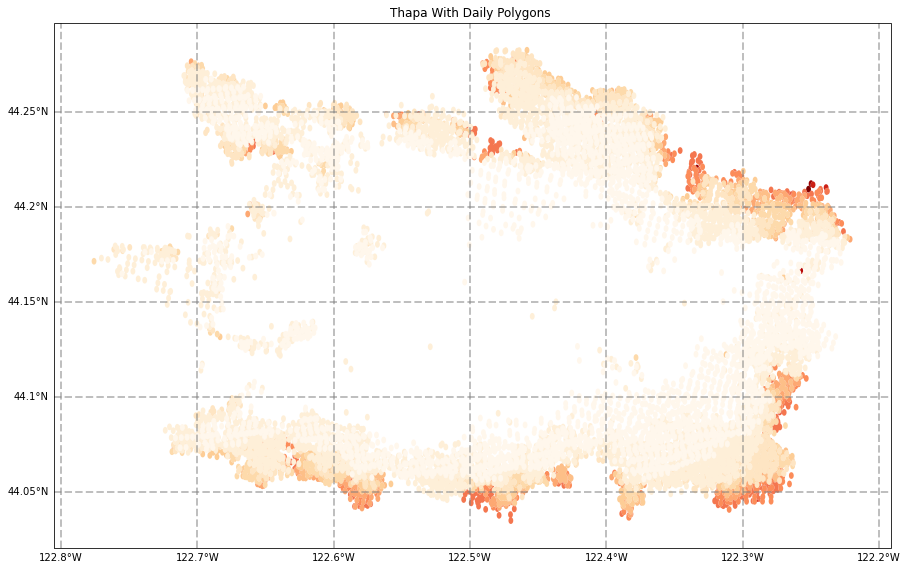

In [37]:

fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
#ax.set_extent([-124, -122, 39.2,40.5])
ac_thapa_daily.plot(column = ac_thapa_daily['Current Day'], ax=ax, cmap='OrRd')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Thapa With Daily Polygons ')
plt.show()

## Make sure the polygons are rounded and Generate the Times
times can't go past the first of November

In [4]:
if np.datetime64(ac_thapa_daily['Current Day'].iloc[len(ac_thapa_daily)-1])>np.datetime64('2020-11-01'):
    end_day = np.datetime64('2020-11-01')
else:
    end_day = np.datetime64(ac_thapa_daily['Current Day'].iloc[len(ac_thapa_daily)-1])+np.timedelta64(1,'D')

print(end_day)
times = np.arange(np.datetime64(ac_thapa_daily['Current Day'].iloc[0]),\
                          end_day)
print(times)

2020-10-10
['2020-09-09' '2020-09-10' '2020-09-11' '2020-09-12' '2020-09-13'
 '2020-09-14' '2020-09-15' '2020-09-16' '2020-09-17' '2020-09-18'
 '2020-09-19' '2020-09-20' '2020-09-21' '2020-09-22' '2020-09-23'
 '2020-09-24' '2020-09-25' '2020-09-26' '2020-09-27' '2020-09-28'
 '2020-09-29' '2020-09-30' '2020-10-01' '2020-10-02' '2020-10-03'
 '2020-10-04' '2020-10-05' '2020-10-06' '2020-10-07' '2020-10-08'
 '2020-10-09']


### MERRA Time Series

In [ ]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
temp=np.zeros(len(times))
vpd=np.zeros(len(times))
num_points = np.zeros(len(times))
frp = np.zeros(len(times))
wind =  np.zeros(len(times))
area = np.zeros(len(times))
hd0w0 = np.zeros(len(times))
hd1w0 = np.zeros(len(times))
hd2w0 = np.zeros(len(times))

varis = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['TLML', 'QLML']}
dims = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['lat', 'lon', 'time']}
time_extract= {'TLML':12, 'QLML':12, 'SPEEDLML':12, 'PS':12}


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_merra = '/data2/lthapa/'+yr+'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if '*' in path_merra:
        path_merra = path_merra.replace('*', yr+mo+dy)
    if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
        path_merra = path_merra.replace('400', '401')
    dat = nc.Dataset(path_merra)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    t = dat['time'][:]
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    T = dat['TLML'][:]
    Q = dat['QLML'][:]
    P = dat['PS'][:]
    W = dat['SPEEDLML'][:]
    print(T.shape)
    
    esat = sat_vap_press(T)
    e = vap_press(Q,P)
    VPD = esat-e
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    
    #does a polygon exist for this time?
    
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    print(thapa_ind)
    print(len(thapa_ind[0]))
    
    if (len(thapa_ind[0])==0):
        print(ii, 'No Thapa poly!')
        temp[ii] = np.nan
        vpd[ii] = np.nan
        wind[ii]= np.nan
        num_points[ii] = np.nan
        area[ii] = np.nan
    
    else:
        print(ii, 'Yes Thapa Poly!')
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        temp[ii] = np.max(feature_hourly(T, overlap_thapa))
        vpd[ii] = np.max(feature_hourly(VPD, overlap_thapa))
        wind[ii]= np.max(feature_hourly(W, overlap_thapa))
        frp[ii] = ac_thapa_daily['NEW FRP'].iloc[thapa_ind[0]]
        num_points[ii] = ac_thapa_daily['Number of NEW VIIRS points'].iloc[thapa_ind[0]]
        area[ii] = ac_thapa_daily['geometry'].iloc[thapa_ind[0]].area

In [ ]:
df_merra = pd.DataFrame({'day': times,'temp':temp, 'vpd':vpd, 'wind':wind, 'frp':frp, 'num points': num_points, 'area':area})
df_merra

df_merra.to_csv('AC_Daily_MERRA.csv')

### MERRA Time Series with Lags

In [50]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
temp=np.zeros(len(times))
vpd=np.zeros(len(times))
num_points = np.zeros(len(times))
frp = np.zeros(len(times))
wind =  np.zeros(len(times))
area = np.zeros(len(times))
hd0w0 = np.zeros(len(times))
hd1w0 = np.zeros(len(times))
hd2w0 = np.zeros(len(times))

varis = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['TLML', 'QLML']}
dims = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['lat', 'lon', 'time']}
time_extract= {'TLML':12, 'QLML':12, 'SPEEDLML':12, 'PS':12}


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_merra = '/data2/lthapa/'+yr+'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    
    #does a polygon exist for this time?
    
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    print(thapa_ind)
    print(len(thapa_ind[0]))
    
    if (len(thapa_ind[0])==0):
        print(ii, 'No Thapa poly!')
        temp[ii] = np.nan
        vpd[ii] = np.nan
        wind[ii]= np.nan
        hd0w0[ii] = np.nan
        hd1w0[ii] = np.nan
        hd2w0[ii] = np.nan
        num_points[ii] = np.nan
        area[ii] = np.nan
        frp[ii] = np.nan
        
    else:
        print(ii, 'Yes Thapa Poly!')
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        
        #get the MERRA Stuff
        out = extract_polygon_history(times[ii], 2, path_merra, 'lat', 'lon', {'TLML', 'QLML', 'PS', 'SPEEDLML'},\
                            poly_thapa, 'rectilinear', 1, 'max')

        #Get the derived stuff
        esat = sat_vap_press(out['TLML'].iloc[:])
        e = vap_press(out['QLML'].iloc[:], out['PS'].iloc[:])
        VPD = esat-e
        out = pd.concat([out, pd.DataFrame({'ESAT':esat, 'E': e, 'VPD':VPD})],\
                        axis=1)
        #print(out) #first row is ndays back
        out_max = out.groupby(['time']).max()
        #print(out_max)
        
        temp[ii] = out_max['TLML'].iloc[2]
        vpd[ii] = out_max['VPD'].iloc[2]
        wind[ii]= out_max['SPEEDLML'].iloc[2]
        hd0w0[ii] = out_max['VPD'].iloc[2]*out_max['SPEEDLML'].iloc[2]
        hd1w0[ii] = out_max['VPD'].iloc[1]*out_max['SPEEDLML'].iloc[2]
        hd2w0[ii] =out_max['VPD'].iloc[0]*out_max['SPEEDLML'].iloc[2]
        frp[ii] = ac_thapa_daily['NEW FRP'].iloc[thapa_ind[0]]
        num_points[ii] = ac_thapa_daily['Number of NEW VIIRS points'].iloc[thapa_ind[0]]
        area[ii] = ac_thapa_daily['geometry'].iloc[thapa_ind[0]].area

0
(array([0]),)
1
0 Yes Thapa Poly!
['2020-09-07' '2020-09-08' '2020-09-09']
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
-123.756959092448 43.054823907552 -121.225958907552 45.269196092448
2 6 24 29
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
1
(array([1]),)
1
1 Yes Thapa Poly!
['2020-09-08' '2020-09-09' '2020-09-10']
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
-123.772088092448 43.044296907551995 -121.223296907552 45.278569092448
2 6 24 29
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
2
(array([2]),)
1
2 Yes Thapa Poly!
['2020-09-09' '2020-09-10' '2020-09-11']
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
-123.762993092448 43.045298907551995 -121.223257907552 45.284183092448
2 6 24 29


TopologyException: side location conflict at -122.59571937373448 44.247717034585705


/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
3
(array([3]),)
1
3 Yes Thapa Poly!
['2020-09-10' '2020-09-11' '2020-09-12']
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
-123.777513092448 43.044108907552 -121.22405233169104 45.281472092448
2 6 24 29
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
4
(array([4]),)
1
4 Yes Thapa Poly!
['2020-09-11' '2020-09-12' '2020-09-13']
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
-123.72419092391321 43.041516907552 -121.221206907552 45.284363092448004
2 6 24 29
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
5
(array([5]),)
1
5 Yes Thapa Poly!
['2020-09-12' '2020-09-13' '2020-09-14']
/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4
-123.7055166

In [51]:
df_merra = pd.DataFrame({'day': times,'temp':temp, 'vpd':vpd, 'wind':wind,\
                         'hd0w0':hd0w0, 'hd1w0':hd1w0,'hd2w0':hd2w0,
                         'frp':frp, 'num points': num_points, 'area':area})
df_merra

#df_merra.to_csv('AC_Daily_MERRA.csv')
#df_merra.to_csv('BOBCAT_Daily_MERRA.csv')
df_merra.to_csv('HOLIDAY_FARM_Daily_MERRA.csv')

### FCCS Time Series

In [ ]:
varis = {'/static_maps/static_map_1km.nc4': ['fccs', 'slp', 'asp']}
#0=lat, 1=lon, 2=time, 3=level 
dims = {'/static_maps/static_map_1km.nc4': ['lat', 'lon']}

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
fuels = np.zeros(len(times))
slopes = np.zeros(len(times))
aspects = np.zeros(len(times))

# load in the FCCS Data
path = '../static_maps/static_map_1km.nc4'
dat = nc.Dataset(path)  

lat = dat['lat'][:]
lon = dat['lon'][:]
fccs = dat['fccs'][:]
slp = dat['slp'][:]
asp = dat['asp'][:]

if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat) 
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)

for ii in range(len(times)):
    tic = np.datetime64('now')
    print(ii)
    
    #does a polygon exist for this time?
    
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        fuels[ii] = np.nan
        slopes[ii] = np.nan
        aspects[ii]= np.nan
        
    else:
        print(ii, 'Yes Thapa poly!')
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0],'rectilinear',0.01)
        overlap_thapa_buff = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0].buffer(0.05),'rectilinear',0.01) #0.05 degree buffer to check fuels 
        fuels[ii] = find_mode(fccs[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
        slopes[ii] = np.nanmax(slp[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
        aspects[ii] = find_mode(asp[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
    toc= np.datetime64('now')
    print(toc-tic)

0
0 Yes Thapa poly!
-122.854590092448 39.554956907552 -122.63870690755199 39.773554092448
189 208 951 976
-122.90452986525821 39.505017134741784 -122.58876713474179 39.823493865258214
185 213 946 981
1 seconds
1
1 Yes Thapa poly!
-122.96660309244801 39.463414907552 -122.43718690755199 39.802370092448
179 226 941 979


TopologyException: side location conflict at -122.73582130537416 39.583134305374159
TopologyException: side location conflict at -122.73582130537416 39.583134305374159
TopologyException: found non-noded intersection between LINESTRING (-122.635 39.5825, -122.635 39.5825) and LINESTRING (-122.635 39.5825, -122.635 39.5825) at -122.63520448670994 39.582524005728892
TopologyException: side location conflict at -122.70293921512099 39.597316037726571
TopologyException: found non-noded intersection between LINESTRING (-122.635 39.5825, -122.635 39.5825) and LINESTRING (-122.635 39.5825, -122.635 39.5825) at -122.63520448670994 39.582524005728892
TopologyException: found non-noded intersection between LINESTRING (-122.715 39.5932, -122.715 39.5932) and LINESTRING (-122.715 39.5932, -122.715 39.5933) at -122.71488795254623 39.59322203571913
TopologyException: found non-noded intersection between LINESTRING (-122.715 39.5932, -122.715 39.5932) and LINESTRING (-122.715 39.5932, -122.715 39.5933)

In [ ]:
ac_dict = {'Day': times, 'fuels': fuels, 'slopes':slopes, 'aspects':aspects}

df_ac = pd.DataFrame(ac_dict)
df_ac
df_ac.to_csv('AC_FCCS.csv')



### Rave Time Series Thapa polygon only (created 5/2/2022)

In [52]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for

df_rave_thapa = pd.DataFrame({'Mean_FRP':np.zeros(len(times)),\
                          'FRE':np.zeros(len(times)),  'CO2':np.zeros(len(times)),  'CO':np.zeros(len(times)),\
                          'SO2':np.zeros(len(times)),  'OC':np.zeros(len(times)),  'BC':np.zeros(len(times)),\
                          'PM2.5':np.zeros(len(times)),  'NOx':np.zeros(len(times)),  'NH3':np.zeros(len(times))})
#loop over times
#loop over variables
# put it all into a dataframe

varis = ['Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC', 'PM2.5', 'NOx', 'NH3'] #don't need 'area', it's the area of each cell
path_prefix = '/data2/lthapa/2020/Apr2020_to_Oct2020/'
file_prefix = 'Hourly_Emissions_FV3_13km_'

for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    
    path_gbbepx = path_prefix + file_prefix + yr+mo+dy+'0000_'+yr+mo+dy+'2300.nc'
    dat = nc.Dataset(path_gbbepx) # load in the data
    lat_corner = dat['Latitude'][:] #get the lat/lons
    lon_corner = dat['Longitude'][:]-360 #need to convert to degrees west or negative lon
    lat_center, lon_center = calculate_grid_cell_corners(lat_corner, lon_corner)
    
    print(lat_corner.shape, lat_center.shape)

    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        df_rave_thapa.iloc[ii] = np.nan*np.zeros((1,10)) #nan for this instance
            
    else:
        print(ii, 'Thapa poly available!')
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_center,lon_center,lat_corner,lon_corner,poly_thapa.iloc[0], 'curvilinear',1)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        # print(np.where(overlap_thapa!=0))
        for var in varis:
            field = np.swapaxes(np.swapaxes(dat[var][:], 0,2), 1,2)
            df_rave_thapa[var].iloc[ii] = np.sum(feature_hourly(field, overlap_thapa))


    #fig = plt.figure(figsize=(15,10))
    #ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
    #ax.coastlines()
    #ax.set_extent([-123.4, -122.6, 39.4, 40.5])
    #ax.coastlines()
    #ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
    #plt.scatter(lon_center,lat_center, c=np.sum(field, axis=0))
    #poly_thapa.plot(ax=ax, color ='r', alpha=0.5)
    #plt.title('GPPEPx OC Daily Emissions: '+yr+mo+dy)
    #plt.colorbar()
    #plt.show()    
            
df_rave_thapa

0
(233, 397) (232, 396)
0 Thapa poly available!
-123.756959092448 43.054823907552 -121.225958907552 45.269196092448
36 55 175 196
1
(233, 397) (232, 396)
1 Thapa poly available!
-123.772088092448 43.044296907551995 -121.223296907552 45.278569092448
36 55 175 197


TopologyException: found non-noded intersection between LINESTRING (-122.296 44.0762, -122.296 44.0763) and LINESTRING (-122.296 44.0763, -122.296 44.0763) at -122.29594128407787 44.076313689697685
TopologyException: found non-noded intersection between LINESTRING (-122.533 44.2284, -122.533 44.2286) and LINESTRING (-122.533 44.2285, -122.533 44.2285) at -122.53278880072266 44.228516995391253
TopologyException: found non-noded intersection between LINESTRING (-122.536 44.2381, -122.536 44.238) and LINESTRING (-122.536 44.238, -122.536 44.238) at -122.5358364792789 44.238016878919467


2
(233, 397) (232, 396)
2 Thapa poly available!
-123.762993092448 43.045298907551995 -121.223257907552 45.284183092448
36 55 175 197


TopologyException: side location conflict at -122.28530831834206 44.060504095576562


3
(233, 397) (232, 396)
3 Thapa poly available!
-123.777513092448 43.044108907552 -121.22405233169104 45.281472092448
36 55 175 197
4
(233, 397) (232, 396)
4 Thapa poly available!
-123.72419092391321 43.041516907552 -121.221206907552 45.284363092448004
36 55 175 197
5
(233, 397) (232, 396)
5 Thapa poly available!
-123.705516646316 43.038336907552 -121.235756907552 45.27614125308779
36 55 175 197
6
(233, 397) (232, 396)
6 Thapa poly available!
-123.706263092448 43.036631907552 -121.219359907552 45.278333092448
36 55 175 197
7
(233, 397) (232, 396)
7 Thapa poly available!
-123.6673568816863 43.035026907552 -121.22556190755199 45.278092092448
36 55 175 197
8
(233, 397) (232, 396)
8 Thapa poly available!
-123.71878944214852 43.033301907552 -121.224246907552 45.28125075718586
36 55 175 197
9
(233, 397) (232, 396)
9 Thapa poly available!
-123.27440138058824 43.090483907552 -121.26233812718893 45.208779092448005
39 55 175 195
10
(233, 397) (232, 396)
10 No Thapa poly!
11
(233, 397) (232, 396)

,Mean_FRP,FRE,CO2,CO,SO2,OC,BC,PM2.5,NOx,NH3
0,385542.452231,1.387953e+09,8.164605e+08,4.525393e+07,357536.661200,5.567357e+06,280921.671782,6.537813e+06,975564.321059,429043.983802
1,127499.633272,4.589987e+08,2.700051e+08,1.496556e+07,118238.063837,1.841136e+06,92901.340383,2.162068e+06,322621.005749,141885.676010
2,61727.005633,2.222172e+08,1.307188e+08,7.245348e+06,57243.157578,8.913577e+05,44976.768855,1.046732e+06,156192.044215,68691.787122
3,18352.522784,6.606908e+07,3.886501e+07,2.154169e+06,17019.396120,2.650163e+05,13372.383254,3.112118e+05,46438.638006,20423.274779
4,18660.767540,6.717876e+07,3.951777e+07,2.190350e+06,17305.250046,2.694675e+05,13596.982657,3.164389e+05,47218.611049,20766.299513
5,5033.131871,1.811927e+07,1.065863e+07,5.907753e+05,4667.525321,7.268004e+04,3667.341541,8.534904e+04,12735.676402,5601.030286
6,2953.969154,1.063429e+07,6.255599e+06,3.467289e+05,2739.392910,4.265626e+04,2152.380239,5.009176e+04,7474.629234,3287.271468
7,14544.874161,5.236155e+07,3.080158e+07,1.707238e+06,13488.334808,2.100326e+05,10597.977943,2.466438e+05,36803.885468,16186.001709
8,4885.210566,1.758676e+07,1.034538e+07,5.734128e+05,4530.349115,7.054401e+04,3559.560131,8.284067e+04,12361.380955,5436.418804
9,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000


In [53]:
# save the rave
df_rave_thapa
#df_rave_thapa.to_csv('AC_Daily_RAVE.csv')
#df_rave_thapa.to_csv('BOBCAT_Daily_RAVE.csv')
df_rave_thapa.to_csv('HOLIDAY_FARM_Daily_RAVE.csv')

### COD Time Series

In [ ]:
#COD Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for

cod_out =  np.zeros((2, len(times)))


#loop over times
#loop over variables
# put it all into a dataframe

varis = ['cod'] #don't need 'area', it's the area of each cell
path_prefix = '/data2/lthapa/2020/COD_Aggregated/'
file_prefix = 'MAX_COD_'

#load in one file for shapes
dat_test = nc.Dataset('/data2/lthapa/2020/COD_Aggregated/MAX_COD_2020112821.nc')
data_cod = nc.Dataset('/data2/lthapa/2019/COD/201908615/OR_ABI-L2-CODC-M3_G16_s20190861502162_e20190861504535_c20190861506227.nc')
lat_ctr, lon_ctr = project_abi(data_cod)
lat_corner, lon_corner = calculate_grid_cell_corners(lat_ctr, lon_ctr)

#print((24, lat_test.shape[0], lat_test.shape[1]))
for ii in range(len(times)):
    print(ii)
    cod = np.zeros((24, lat_ctr.shape[0], lat_ctr.shape[1])) #preallocate an array for COD
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    
    
    path_cod = path_prefix + file_prefix + yr+mo+dy+'*.nc'
    hr = 0
    for item in os.listdir(path_prefix):
        if (yr+mo+dy in item) and (file_prefix in item):
            #build the grid that contains info for the day
            path_cod =path_prefix + item
            #print(path_cod)
            dat = nc.Dataset(path_cod) # load in the data
            lat_corner, lon_corner =calculate_grid_cell_corners(lat_ctr, lon_ctr)
            cod[hr,:] = dat['cod'][0,:]
            hr=hr+1
            
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    if len(mcclure_ind[0])==0:
        print('No McClure poly!')
        cod_out[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_thapa.iloc[0],'curvilinear',0.05)
        print(overlap_thapa.shape)
        cod_out[1,ii] = np.max(feature_hourly(cod, overlap_thapa))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        cod_out[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_mcclure.iloc[0],'curvilinear',0.05)
        print(overlap_mcclure.shape)
        cod_out[0,ii] = np.max(feature_hourly(cod, overlap_mcclure))
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_mcclure.iloc[0], 'curvilinear',0.05)
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_thapa.iloc[0], 'curvilinear',0.05)
        cod_out[0,ii] = np.max(feature_hourly(cod, overlap_mcclure))
        cod_out[1,ii] = np.max(feature_hourly(cod, overlap_thapa))

### NCAR Fuel Moisture (revised 5/5/2022)

In [18]:
#NCAR Moisture Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
mlive=np.zeros((2, len(times)))
mdead=np.zeros((2, len(times)))


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_fmc = '/data2/lthapa/2020/FMC/fmc_*_20Z.nc'

    if '*' in path_fmc:
        path_fmc = path_fmc.replace('*', yr+mo+dy)
    print(path_fmc)
    
    try:
        dat = nc.Dataset(path_fmc)  
    except:
        print("No file for this day")
        mlive[1,ii] = np.nan
        mdead[1,ii] = np.nan
        continue
        
    lat = dat['XLAT_M'][0,:]
    lon = dat['XLONG_M'][0,:]
    print(lon.shape)
    #t = dat['time'][:]
    
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    living = dat['FMCGLH2D'][0,:]
    dead = dat['FMCG2D'][0,:]
    print(living)
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    

    #does a polygon exist for this time?
    
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
        
    if len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        mlive[1,ii] = np.nan
        mdead[1,ii] = np.nan

    else:
        print(ii, 'Yes Thapa polys')        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]].buffer(0.00001)
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'curvilinear',0.05)
        mlive[1,ii] = np.mean(feature_hourly(living, overlap_thapa))
        mdead[1,ii] = np.mean(feature_hourly(dead, overlap_thapa))

0
/data2/lthapa/2020/FMC/fmc_20200909_20Z.nc
No file for this day
1
/data2/lthapa/2020/FMC/fmc_20200910_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1 Yes Thapa polys
-122.82209808 43.99428692 -122.17328692000001 44.32857908
690 749 2466 2514
2
/data2/lthapa/2020/FMC/fmc_20200911_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
2 Yes Thapa polys
-122.81300308040255 43.995288919597435 -122.17324791959744 44.334193080402564
691 749 2466 2515
3
/data2/lthapa/2020/FMC/fmc_20200912_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
3 Yes Thapa polys
-122.82752308040256 43.99409891959744 -122.17404234373649 44.33148

30 Yes Thapa polys
-122.30339308040256 44.15773691959744 -122.19984691959745 44.26128308040256
735 745 2484 2496


In [19]:
print(mlive)
#print(mdead)

moisture = {'DateTim': times, 'mlive': mlive[1,:],'mdead': mdead[1,:]}
df_moisture = pd.DataFrame(moisture)
df_moisture
#df_moisture.to_csv('AC_Daily_NCAR_Moisture.csv')
#df_moisture.to_csv('BOBCAT_Daily_NCAR_Moisture.csv')
df_moisture.to_csv('HOLIDAY_FARM_Daily_NCAR_Moisture.csv')

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [       nan 0.97159827 0.94824449 0.89408162 0.98700176 0.98091852
  1.02446023 0.9874586  0.96886164 0.92349508        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan 0.60185524        nan        nan        nan
         nan 0.49912671        nan 0.69666894 0.60288997        nan
  0.57185686]]


### IGBP Fuels (created 4/13/2022)

In [ ]:
#NCAR Moisture Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
df_igbp_thapa = pd.DataFrame({'% water':np.zeros(len(times)), '% evergreen needleleaf forest':np.zeros(len(times)),\
                              '% evergreen broadleaf forest':np.zeros(len(times)),\
                              '% deciduous needleleaf forest':np.zeros(len(times)),\
                               '% deciduous broadleaf forest':np.zeros(len(times)), '% mixed forests':np.zeros(len(times)),\
                              '% closed shrubland':np.zeros(len(times)), '% open shrublands':np.zeros(len(times)),\
                              '% woody savannas':np.zeros(len(times)),'% savannas':np.zeros(len(times)),\
                              '% grasslands':np.zeros(len(times)), '% permanent wetlands':np.zeros(len(times)),\
                              '% croplands':np.zeros(len(times)), '% urban and built-up':np.zeros(len(times)),\
                              '% cropland/natural vegetation mosaic':np.zeros(len(times)),\
                              '% snow and ice':np.zeros(len(times)),\
                              '% barren or sparsely vegetated':np.zeros(len(times))})

df_igbp_mcclure = pd.DataFrame({'% water':np.zeros(len(times)), '% evergreen needleleaf forest':np.zeros(len(times)),\
                              '% evergreen broadleaf forest':np.zeros(len(times)),\
                              '% deciduous needleleaf forest':np.zeros(len(times)),\
                               '% deciduous broadleaf forest':np.zeros(len(times)), '% mixed forests':np.zeros(len(times)),\
                              '% closed shrubland':np.zeros(len(times)), '% open shrublands':np.zeros(len(times)),\
                              '% woody savannas':np.zeros(len(times)),'% savannas':np.zeros(len(times)),\
                              '% grasslands':np.zeros(len(times)), '% permanent wetlands':np.zeros(len(times)),\
                              '% croplands':np.zeros(len(times)), '% urban and built-up':np.zeros(len(times)),\
                              '% cropland/natural vegetation mosaic':np.zeros(len(times)),\
                              '% snow and ice':np.zeros(len(times)),\
                              '% barren or sparsely vegetated':np.zeros(len(times))})
#load in the data here so we only have to do it once

dat = nc.Dataset('/data2/lthapa/static_maps/MODIS_IGBP_2020.nc')
lat_center = dat['lat'][:]
lon_center = dat['lon'][:]
lc_majority= dat['lc_majority'][:]
lc_percent = dat['lc_percent'][:]
print(lc_percent.shape)

lat_inds = np.where((lat_center[:,0]>=31)& (lat_center[:,0]<=51))[0]
lat_start = lat_inds[0]
lat_end = lat_inds[len(lat_inds)-1]
lon_inds = np.where((lon_center[0,:]>=-126)& (lon_center[0,:]<=-101))[0]
lon_start = lon_inds[0]
lon_end = lon_inds[len(lon_inds)-1]

lat_corners, lon_corners = calculate_grid_cell_corners(lat_center, lon_center)

for ii in range(len(times)):
    print(ii)
    
    #does a polygon exist for this time?
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_center,lon_center,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',0.05)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        overlap_thapa[np.where(overlap_thapa==0)]=np.nan
        for jj in range(17):
            df_igbp_mcclure.iloc[ii,jj] = np.nan 
            df_igbp_thapa.iloc[ii,jj] = np.nanmean(np.multiply(overlap_thapa, lc_percent[jj, :,:]))#average percentage over polygon of each fuel


    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_center,lon_center,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',0.05)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        overlap_mcclure[np.where(overlap_mcclure==0)]=np.nan
        for jj in range(17):
            df_igbp_mcclure.iloc[ii,jj] = np.nanmean(np.multiply(overlap_mcclure, lc_percent[jj, :,:])) #average percentage over polygon of each fuel
            df_igbp_thapa.iloc[ii,jj] = np.nan

    else:
        print(ii, 'both polys')
        
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_center,lon_center,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',0.05)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        overlap_mcclure[np.where(overlap_mcclure==0)]=np.nan
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_center,lon_center,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',0.05)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        overlap_thapa[np.where(overlap_thapa==0)]=np.nan
        
        for jj in range(17):
            df_igbp_mcclure.iloc[ii,jj] = np.nanmean(np.multiply(overlap_mcclure, lc_percent[jj, :,:])) #average percentage over polygon of each fuel
            df_igbp_thapa.iloc[ii,jj] = np.nanmean(np.multiply(overlap_thapa, lc_percent[jj, :,:]))


            
df_igbp_thapa

In [ ]:
df_igbp_thapa.to_csv('AC_IGBP_Thapa.csv')
df_igbp_mcclure.to_csv('AC_IGBP_McClure.csv')

In [ ]:
 #this plots the fuel types with polygons overlaid  
    
    fig = plt.figure(figsize=(15,10))
        ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([-123.5, -122.3, 39.4, 40.5])
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
        print(levels)
        fuelmap = plt.contourf(lon_center[lat_start:lat_end, lon_start:lon_end],\
            lat_center[lat_start:lat_end, lon_start:lon_end],\
           lc_majority[lat_start:lat_end, lon_start:lon_end],\
            levels=levels,cmap='gist_ncar')
        gpd.GeoSeries(poly_mcclure).plot(ax=ax, color='w', alpha=0.75)
        plt.show()

## Time Series Map McClure IGBP

In [ ]:
#NCAR Moisture Time Series

dat = nc.Dataset('/data2/lthapa/static_maps/MODIS_IGBP_2020.nc')
lat_center = dat['lat'][:]
lon_center = dat['lon'][:]
lc_majority= dat['lc_majority'][:]
lc_percent = dat['lc_percent'][:]
print(lc_percent.shape)

lat_inds = np.where((lat_center[:,0]>=31)& (lat_center[:,0]<=51))[0]
lat_start = lat_inds[0]
lat_end = lat_inds[len(lat_inds)-1]
lon_inds = np.where((lon_center[0,:]>=-126)& (lon_center[0,:]<=-101))[0]
lon_start = lon_inds[0]
lon_end = lon_inds[len(lon_inds)-1]

lat_corners, lon_corners = calculate_grid_cell_corners(lat_center, lon_center)

for ii in range(len(times)):
    print(ii)
    
    #does a polygon exist for this time?
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')

    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        
        fig = plt.figure(figsize=(15,10))
        ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([-123.5, -122.3, 39.4, 40.5])
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
        print(levels)
        fuelmap = plt.contourf(lon_center[lat_start:lat_end, lon_start:lon_end],\
            lat_center[lat_start:lat_end, lon_start:lon_end],\
           lc_majority[lat_start:lat_end, lon_start:lon_end],\
            levels=levels,cmap='gist_ncar')
        gpd.GeoSeries(poly_mcclure).plot(ax=ax, color='w', alpha=0.75)
        plt.title('McClure Polygon '+ str(times[ii]))
        plt.show()

    else:
        print(ii, 'both polys')
        
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        fig = plt.figure(figsize=(15,10))
        ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([-123.5, -122.3, 39.4, 40.5])
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
        print(levels)
        fuelmap = plt.contourf(lon_center[lat_start:lat_end, lon_start:lon_end],\
            lat_center[lat_start:lat_end, lon_start:lon_end],\
           lc_majority[lat_start:lat_end, lon_start:lon_end],\
            levels=levels,cmap='gist_ncar')
        
        gpd.GeoSeries(poly_thapa).plot(ax=ax, color='w', alpha=0.5)
        gpd.GeoSeries(poly_mcclure).plot(ax=ax, color='w', alpha=0.75)
        plt.title('McClure Polygon '+ str(times[ii]))
        plt.show()

            
df_igbp_thapa

## Resources time series

In [20]:
print(type(times))

resources = pd.read_excel('Query2.xlsx')
resources_people = resources.drop(columns=['RESTYP_IDENTIFIER', 'CODE_NAME', 'INC209R_IDENTIFIER'])
#resources_people = resources_people.groupby(['INC209R_IDENTIFIER']).sum()
resources_people

<class 'numpy.ndarray'>


,INCIDENT_NAME,REPORT_FROM_DATE,REPORT_TO_DATE,RESOURCE_QUANTITY,RESOURCE_PERSONNEL,INC_IDENTIFIER
0,Dogwood Trail,1/8/2020 12:30:00 PM,1/8/2020 9:15:00 PM,2.0,2,11683717
1,Dogwood Trail,1/8/2020 12:30:00 PM,1/8/2020 9:15:00 PM,2.0,2,11683717
2,Dogwood Trail,1/8/2020 12:30:00 PM,1/8/2020 9:15:00 PM,NaN,0,11683717
3,Dogwood Trail,1/9/2020 12:30:00 PM,1/10/2020 8:15:00 AM,2.0,2,11683717
4,Dogwood Trail,1/9/2020 12:30:00 PM,1/10/2020 8:15:00 AM,2.0,2,11683717
...,...,...,...,...,...,...
142648,FOOT PRINT,12/30/2020 10:00:00 AM,12/31/2020 1:30:00 PM,NaN,0,11981111
142649,SMALL PINES,12/24/2020 12:01:00 AM,12/24/2020 3:10:00 PM,1.0,1,11981205
142650,SMALL PINES,12/24/2020 12:01:00 AM,12/24/2020 3:10:00 PM,1.0,1,11981205
142651,SMALL PINES,12/24/2020 12:01:00 AM,12/24/2020 3:10:00 PM,1.0,1,11981205


In [22]:
ac_inds = np.where(resources_people['INCIDENT_NAME']=='Holiday Farm')[0] #pull out august complex

resources_people_ac = resources_people.iloc[ac_inds]

#get the days (in UTC) that the 209 reports are valid for
resources_dates = pd.to_datetime(resources_people_ac['REPORT_FROM_DATE']) + datetime.timedelta(hours=7)
#resources_dates
resources_days = [resources_dates.iloc[i].strftime("%Y-%m-%d") for i in range(len(resources_dates))]
resources_people_ac['DateTim'] = resources_days

print(resources_people_ac)

       INCIDENT_NAME       REPORT_FROM_DATE         REPORT_TO_DATE  \
117024  Holiday Farm   9/8/2020 12:17:00 AM    9/8/2020 8:45:00 PM   
117025  Holiday Farm   9/8/2020 12:17:00 AM    9/8/2020 8:45:00 PM   
117026  Holiday Farm   9/8/2020 12:17:00 AM    9/8/2020 8:45:00 PM   
117027  Holiday Farm   9/8/2020 12:17:00 AM    9/8/2020 8:45:00 PM   
117028  Holiday Farm    9/8/2020 8:45:00 PM    9/9/2020 8:00:00 PM   
...              ...                    ...                    ...   
118072  Holiday Farm  10/23/2020 4:30:00 PM  10/24/2020 4:30:00 PM   
118073  Holiday Farm  10/27/2020 8:00:00 AM  10/29/2020 5:00:00 PM   
118074  Holiday Farm  10/27/2020 8:00:00 AM  10/29/2020 5:00:00 PM   
118075  Holiday Farm  10/25/2020 4:30:00 PM  10/26/2020 7:30:00 PM   
118076  Holiday Farm  10/25/2020 4:30:00 PM  10/26/2020 7:30:00 PM   

        RESOURCE_QUANTITY  RESOURCE_PERSONNEL  INC_IDENTIFIER     DateTim  
117024                7.0                  21        11926606  2020-09-08  
117025 

In [23]:
#sum up the personnel assigned to the fire each day
daily_sum_people = resources_people_ac.groupby('DateTim', as_index=False).sum()

print(daily_sum_people)

personnel=np.zeros(len(times))

for ii in range(len(times)):
    print(ii)    
    
    #does a report exist for this time?
    thapa_ind = np.where(daily_sum_people['DateTim'] == str(times[ii]))
    print(thapa_ind)
    
    if (len(thapa_ind[0])==0):
        print(ii, 'No report!')
        personnel[ii] = np.nan
        
    else:
        print(ii, 'Yes report!')
        personnel[ii] = daily_sum_people['RESOURCE_PERSONNEL'].iloc[thapa_ind[0]]
        
print(personnel)

       DateTim  RESOURCE_QUANTITY  RESOURCE_PERSONNEL  INC_IDENTIFIER
0   2020-09-08               21.0                  81        47706424
1   2020-09-09               34.0                 207       166972484
2   2020-09-10               83.0                 425       286238544
3   2020-09-11              105.0                 538       357798180
4   2020-09-12               94.0                 628       357798180
5   2020-09-13              125.0                 745       369724786
6   2020-09-14              127.0                 767       369724786
7   2020-09-15              138.0                 783       369724786
8   2020-09-16              150.0                 812       369724786
9   2020-09-17              257.0                 886       369724786
10  2020-09-18              242.0                1003       393577998
11  2020-09-19              256.0                1032       393577998
12  2020-09-20              247.0                 985       345871574
13  2020-09-21      

In [24]:
df_personnel = pd.DataFrame({'personnel':personnel})
#df_personnel.to_csv('BOBCAT_Daily_Personnel.csv')
df_personnel.to_csv('HOLIDAY_FARM_Daily_Personnel.csv')

## Put everything into a dataframe (created 4/11/2022)

In [ ]:
# load in the fuel moisture info, extract living and dead

df_moisture = pd.read_csv('Moisture_Info_August_Complex.csv')
df_cod = pd.read_csv()
dict_thapa = {'time':times,'temp':temp[1,:], 'vpd':vpd[1,:], 'wind':wind[1,:], 'personnel':personnel,\
              'dead_moisture':df_moisture['Dead Thapa'], 'living moisture':df_moisture['Live Thapa'],\
              'cod': cod_out[1,:],'frp':frp[1,:], 'num_points':num_points[1,:]}
df_thapa = pd.concat([pd.DataFrame(dict_thapa), df_gbbepx_thapa], axis=1)

dict_mcclure = {'time':times,'temp':temp[0,:], 'vpd':vpd[0,:], 'wind':wind[0,:], 'personnel':personnel,\
              'dead_moisture':df_moisture['Dead McClure'], 'living moisture':df_moisture['Live McClure'],\
              'cod': cod_out[0,:],'frp':frp[0,:], 'num_points':num_points[0,:]}
df_mcclure = pd.concat([pd.DataFrame(dict_mcclure), df_gbbepx_mcclure], axis=1)


#save dataframes
df_thapa.to_csv('AC_Thapa.csv')
df_mcclure.to_csv('AC_McClure.csv')

In [ ]:
df_thapa = pd.read_csv('AC_Thapa.csv')
print(df_thapa.columns)
df_thapa['PM2.5 QFED Rate'] = pm25_daily_rate[1,:]
df_thapa['PM2.5 QFED Total'] = pm25_daily_total[1,:]
df_thapa['PM2.5'] = df_gbbepx_thapa['PM2.5']
print(df_thapa.columns)

df_thapa.to_csv('AC_Thapa.csv')


df_mcclure = pd.read_csv('AC_McClure.csv')
print(df_mcclure.columns)
df_mcclure['PM2.5 QFED Rate'] = pm25_daily_rate[0,:]
df_mcclure['PM2.5 QFED Total'] = pm25_daily_total[0,:]
df_mcclure['PM2.5'] = df_gbbepx_mcclure['PM2.5']
print(df_mcclure.columns)
df_mcclure.to_csv('AC_McClure.csv')


## plot time series

In [ ]:
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[0,:], 'ro-')
ax.plot(times, temp[1,:], 'bo-')
ax.set_ylabel('Temperature', fontsize=24, color='blue')
plt.legend({'McClure Polygons', 'Thapa Polygons'},fontsize=24)
plt.title('AUG COMPLEX MAX DAILY TEMPERATURE',fontsize=24)
plt.grid()
plt.show()

In [ ]:
#compare VPD for the two polygon methods
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[0,:], 'ro-')
ax.plot(times, vpd[1,:], 'bo-')
ax.set_ylabel('Temperature', fontsize=24, color='blue')
plt.legend({'McClure Polygons', 'Thapa Polygons'},fontsize=24)
plt.title('AUG COMPLEX MAX VPD',fontsize=24)
plt.grid()
plt.show()

In [ ]:
#compare FRP for the two polygon methods
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, frp[1,:], 'ro-')
ax.plot(times, frp[0,:], 'bo-')
ax.set_ylabel('FRP', fontsize=24, color='blue')
plt.legend({'McClure Polygons', 'Thapa Polygons'},fontsize=24)
plt.title('AUG COMPLEX FRP',fontsize=24)
plt.grid()
plt.show()

In [ ]:
#compare number of detects/pixels for the two polygon methods
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, num_points[1,:], 'ro-')
ax.plot(times, num_points[0,:], 'bo-')
ax.set_ylabel('Number of points/pixels', fontsize=24, color='blue')
plt.legend({'McClure Polygons pixels', 'Thapa Polygons num points'},fontsize=24)
plt.title('AUG COMPLEX Number Pixels',fontsize=24)
plt.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[1,:], 'ro-')
ax.set_ylabel('Daily Max Vapor Pressure Deficit', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, num_points[1,:], 'bo-')
ax2.set_ylabel('Number of VIIRS Detects', fontsize=24, color='blue')
plt.title('AUG COMPLEX Laura Polygons', fontsize=24)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[1,:], 'ro-')
ax.set_ylabel('Daily Max Temperature', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, num_points[1,:], 'bo-')
ax2.set_ylabel('Number of VIIRS Detects', fontsize=24, color='blue')
plt.title('AUG COMPLEX Laura Polygons', fontsize=24)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[0,:], 'ro-')
ax.set_ylabel('Daily Max Temperature', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, frp[0,:], 'bo-')
ax2.set_ylabel('FRP', fontsize=24, color='blue')
plt.title('AUG COMPLEX Crystal Polygons', fontsize=24)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[0,:], 'ro-')
ax.set_ylabel('Daily Max Vapor Pressure Deficit', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, frp[0,:], 'bo-')
ax2.set_ylabel('FRP', fontsize=24, color='blue')
plt.title('AUG COMPLEX Crystal Polygons', fontsize=24)
plt.show()

## Validate RAVE (created 5/2/2022)

In [ ]:
plot_twoline(times, np.stack([df_gbbepx_thapa['CO'].values, area[1,:]]), 'August Complex Thapa Polygons',\
             [], ['CO Total Emissions (kg)', 'BA (deg^2)'], 1)

print(pd.DataFrame({'emiss':df_gbbepx_thapa['CO'].values, 'area':area[1,:] }).corr())

plot_twoline(times, np.stack([df_gbbepx_mcclure['CO'].values, area[0,:]]), 'August Complex McClure Polygons',\
             [], ['CO Total Emissions (kg)', 'BA (ha)'], 1)

print(pd.DataFrame({'emiss':df_gbbepx_mcclure['CO'].values, 'area':area[0,:] }).corr())


## time series plots with function (3/31/2022)

In [ ]:
plot_twoline(times, num_points, 'August Complex Daily Total Fire Counts', ['McClure', 'Thapa'], '#', 0)
plot_twoline(times, frp, 'August Complex Daily Total FRP', ['McClure', 'Thapa'], 'MW', 0)
plot_twoline(times, area, 'August Complex Daily Burned Area',\
             [], ['McClure Poly (ha)', 'Thapa Poly (degrees^2)'], 1)
print(np.corrcoef(area))
plot_twoline(times, wind, 'August Complex Daily Max WindSpeed', ['McClure', 'Thapa'], 'm/s', 0)
plot_twoline(times, temp, 'August Complex Daily Max Temp', ['McClure', 'Thapa'], 'K', 0)
plot_twoline(times, vpd, 'August Complex Daily Max VPD', ['McClure', 'Thapa'], 'Pa', 0)


In [ ]:
plot_twoline(times, np.stack([temp[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Temperature (K)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([vpd[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max VPD (Pa)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([wind[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Wind (m/s)', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([temp[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Temperature (K)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([vpd[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max VPD (Pa)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([wind[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Wind (m/s)', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([temp[0,:], num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Temperature (K)', 'Num Pixels'], 1)
plot_twoline(times, np.stack([vpd[0,:], num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max VPD (Pa)', 'Num Pixels'], 1)
plot_twoline(times, np.stack([wind[0,:], num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Wind (m/s)', 'Num Pixels'], 1)

plot_twoline(times, np.stack([temp[1,:], num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Temperature (K)', 'Num Detections'], 1)
plot_twoline(times, np.stack([vpd[1,:], num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max VPD (hPa)', 'Num Detections'], 1)
plot_twoline(times, np.stack([wind[1,:], num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Wind (m/s)', 'Num Detections'], 1)



In [ ]:
#personnel comparison
plot_twoline(times, np.stack([personnel, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Number of People', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([personnel, frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Number of People', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([personnel, num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Number of People', 'Fire Counts (#)'], 1)
plot_twoline(times, np.stack([personnel, num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Number of People', 'Fire Counts (#)'], 1)

In [ ]:
# FCCS comparison
df_fuels = pd.read_csv('Fuels_Info_August_Complex.csv')
print(df_fuels)

plot_twoline(times, np.stack([df_fuels['fuels_thapa'].values, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Slopes', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([df_fuels['fuels_mcclure'].values, frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Slopes', 'FRP (MW)'], 1)

In [ ]:
print(df_gbbepx_thapa['CO'].values.shape)

In [ ]:
# GBBEPx Comparison
plot_twoline(times, np.stack([df_gbbepx_thapa['CO'].values, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['CO Total Emissions (kg)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([df_gbbepx_thapa['PM2.5'].values, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['PM2.5 Total Emissions (kg)', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([df_gbbepx_thapa['PM2.5'].values, ac_mcclure_daily['Grwth_A'].values]), 'August Complex Thapa Polygons',\
             [], ['PM2.5 Total Emissions (kg)', 'Burned Area (ha)'], 1)

#plot_twoline(times, np.stack([carbon_monoxide[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
#             [], ['CO Mean Emissions (kg/m2/s)', 'FRP (MW)'], 1)
#plot_twoline(times, np.stack([carbon_monoxide[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
#             [], ['CO Mean Emissions (kg/m2/s)', 'FRP (MW)'], 1)

In [ ]:
#fuel moisture

plot_twoline(times, np.stack([mdead[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([mdead[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Dead Fuel Moisture', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([mlive[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Live Fuel Moisture', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([mlive[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Live Fuel Moisture', 'FRP (MW)'], 1)

In [ ]:
# vpd and fuel moisture
plot_twoline(times, np.stack([mdead[1,:], vpd[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture', 'VPD (Pa)'], 1)
df_test_qfed = pd.DataFrame({'mdead':mdead[1,:], 'VPD':vpd[1,:]})
print(df_test_qfed.corr())

#fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
#plt.scatter(vpd[1,:], mdead[1,:])
#ax.set_xlabel('VPD (Pa)', fontsize=24) 
#ax.set_ylabel('Dead Fuel Moisture', fontsize=24) 
#plt.show()


In [ ]:
# shifting to deal with when we have nans in the cross correlation

n_shift = 0
vpd_shifted = np.concatenate([np.nan*np.zeros(n_shift), vpd[1,0:len(vpd[1,:])-(n_shift)]])
#print(vpd[1,:], vpd_shifted)
#print(len(vpd[1,:]), len(vpd_shifted))

df_test_qfed = pd.DataFrame({'mdead':mdead[1,:], 'VPD':vpd_shifted})
print(df_test_qfed.corr())

plot_twoline(times, np.stack([mdead[1,:], -vpd_shifted]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture', 'Nagative VPD (Pa)'], 1)


fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(vpd_shifted[np.where(frp[1,:]<6000)],mdead[1,np.where(frp[1,:]<6000)], c=frp[1,np.where(frp[1,:]<6000)], cmap='OrRd')
plt.colorbar()
ax.set_xlabel('VPD (Pa)', fontsize=24) 
ax.set_ylabel('Dead Fuel Moisture', fontsize=24) 
plt.show()

## Time Series plots to check QFED (4/12/2022)

In [ ]:
# compare daily qfed rates and totals with GBBEPx

df_thapa = pd.read_csv('AC_Thapa.csv')
print(df_thapa.columns)

print(df_thapa[['PM2.5 QFED Rate', 'frp']].corr())
plot_twoline(times, np.stack([df_thapa['PM2.5 QFED Rate'].values, df_thapa['frp'].values ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Emission Rate (kg/m2/s)', 'VIIRS FRP (MW)'], 1)
print(df_thapa[['PM2.5 QFED Total', 'frp']].corr())
plot_twoline(times, np.stack([df_thapa['PM2.5 QFED Total'].values, df_thapa['frp'].values ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Daily Total (kg)', 'VIIRS FRP (MW)'], 1)
print(df_thapa[['PM2.5', 'frp']].corr())
plot_twoline(times, np.stack([df_thapa['PM2.5'].values, df_thapa['frp'].values ]),\
             'August Complex Thapa Polygons',\
             [], ['GBBEPx PM2.5 Daily Total (kg)', 'VIIRS FRP (MW)'], 1)

In [ ]:
# see if qfed persistence goes with cloud optical depth
print(df_thapa.columns)
print(df_thapa[['PM2.5 QFED Rate', 'cod']].corr())
plot_twoline(times, np.stack([df_thapa['PM2.5 QFED Rate'].values, df_thapa['cod'].values ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Emission Rate (kg/m2/s)', 'Cloud Optical Depth'], 1)

window_size = 10
cod_series = df_thapa['cod']
pm25_series = df_thapa['PM2.5 QFED Rate']
cod_windows = cod_series.rolling(window_size)
pm25_windows = pm25_series.rolling(window_size)

cod_averages=cod_windows.mean()
pm25_std = pm25_windows.std()

df_test = pd.DataFrame({'PM2.5 QFED Rate':pm25_std, '3day Cod':cod_averages})
print(df_test.corr())
plot_twoline(times, np.stack([pm25_std.values, cod_averages.values ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Emission Rate (kg/m2/s)', 'Cloud Optical Depth '+str(window_size)+ 'day average'], 1)


## Time Series Plots IGBP

In [ ]:
df_igbp_thapa = pd.read_csv('AC_IGBP_Thapa.csv')
df_thapa = pd.read_csv('AC_Thapa.csv')
df_combined_thapa = pd.concat([df_thapa[['time']], df_igbp_thapa.drop(columns='Unnamed: 0')], axis=1)

fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_thapa.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,100])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_thapa[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_thapa[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.title('Thapa Polygons')
plt.show()


fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_thapa.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,100])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_thapa[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_thapa[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('Thapa Polygons')
plt.show()


fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_thapa.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,10])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_thapa[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_thapa[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('Thapa Polygons')
plt.show()

fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_thapa.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,2])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_thapa[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_thapa[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('Thapa Polygons')
plt.show()


In [ ]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')

#print(df_igbp_thapa.drop(columns='Unnamed: 0'))
df_combined_mcclure = pd.concat([df_mcclure[['time']], df_igbp_mcclure.drop(columns='Unnamed: 0')], axis=1)

fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_mcclure.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,100])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_mcclure[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.title('McClure Polygons')
plt.show()

fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_mcclure.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,100])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_mcclure[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('McClure Polygons')
plt.show()


fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_mcclure.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,10])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_mcclure[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('McClure Polygons')
plt.show()

fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_mcclure.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,2])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_mcclure[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('McClure Polygons')
plt.show()


In [ ]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')
df_combined_mcclure = pd.concat([df_mcclure[['time', 'living moisture', 'frp', 'vpd']], df_igbp_mcclure.drop(columns='Unnamed: 0')], axis=1)

df_igbp_thapa = pd.read_csv('AC_IGBP_Thapa.csv')
df_thapa = pd.read_csv('AC_Thapa.csv')
df_combined_thapa = pd.concat([df_thapa[['time', 'living moisture', 'frp', 'vpd']], df_igbp_thapa.drop(columns='Unnamed: 0')], axis=1)


corrMatrix_mcclure = df_combined_mcclure.corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix_mcclure, annot=True, vmin=-1, vmax=1,cmap='seismic')
plt.title('McClure Polygons')
plt.show()


corrMatrix_thapa = df_combined_thapa.corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix_thapa, annot=True, vmin=-1, vmax=1,cmap='seismic')
plt.title('Thapa Polygons')
plt.show()

In [ ]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')

df_igbp_thapa = pd.read_csv('AC_IGBP_Thapa.csv')
df_thapa = pd.read_csv('AC_Thapa.csv')

col_names = ['% water', '% evergreen needleleaf forest','% evergreen broadleaf forest',\
                              '% deciduous needleleaf forest',\
                               '% deciduous broadleaf forest', '% mixed forests',\
                              '% closed shrubland', '% open shrublands',\
                              '% woody savannas','% savannas',\
                              '% grasslands', '% permanent wetlands',
                              '% croplands', '% urban and built-up',
                              '% cropland/natural vegetation mosaic',
                              '% snow and ice',\
                             '% barren or sparsely vegetated']
plot_twoline(times, np.stack([df_mcclure['vpd'].values, df_thapa['vpd'].values]), 'VPD',\
            [], ['McClure VPD (Pa)', 'Thapa VPD (Pa)'], 1)

plot_twoline(times, np.stack([df_mcclure['living moisture'].values, df_thapa['living moisture'].values]), 'Living Moisture',\
            [], ['McClure Moisture', 'Thapa Moisture'], 1)

for var in col_names:
    print(var)
    print('McClure Correlations: '+ str(pd.DataFrame({'% fuel':df_igbp_mcclure[var].values, 'moisture':df_mcclure['living moisture'].values}).corr()))
    print('Thapa Correlations: '+ str(pd.DataFrame({'% fuel':df_igbp_thapa[var].values, 'moisture':df_thapa['living moisture'].values}).corr()))

    plot_twoline(times, np.stack([df_igbp_mcclure[var].values, df_igbp_thapa[var].values]), var,\
             [], ['% McClure', '% Thapa'], 1)


In [ ]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')

df_igbp_mcclure = df_igbp_mcclure.drop(columns='Unnamed: 0')
df_igbp_mcclure['time'] = df_mcclure['time'].values

fig,ax=plt.subplots(figsize=(25,20))
df_igbp_mcclure.plot.area(x='time',stacked='True', ax=ax, fontsize=20)
plt.legend(title='Fuel Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.title('Full IGBP Categories', fontsize=24)
plt.show()

In [ ]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')
df_igbp_mcclure = df_igbp_mcclure.iloc[0:52, :]
df_mcclure= df_mcclure.iloc[0:52, :]

df_mcclure_simple = pd.DataFrame({'time':df_mcclure['time'].values,\
                                  'wet': df_igbp_mcclure['% water'].values+df_igbp_mcclure['% permanent wetlands'].values,\
                                 'forest':df_igbp_mcclure['% evergreen needleleaf forest'].values+\
                                  df_igbp_mcclure['% evergreen broadleaf forest'].values+\
                                 df_igbp_mcclure['% deciduous needleleaf forest'].values+\
                                  df_igbp_mcclure['% deciduous broadleaf forest'].values+\
                                  df_igbp_mcclure['% mixed forests'].values,\
                                 'shrub': df_igbp_mcclure['% closed shrubland'].values+\
                                  df_igbp_mcclure['% open shrublands'].values,\
                                 'savanna': df_igbp_mcclure['% woody savannas'].values+\
                                  df_igbp_mcclure['% savannas'].values,\
                                 'grass':df_igbp_mcclure['% grasslands'].values})
fig,ax=plt.subplots(figsize=(25,20))
df_mcclure_simple.plot.area(x='time',stacked='True', ax=ax, fontsize=24)
plt.legend(title='Fuel Category', bbox_to_anchor=(-.25, 1), loc='upper left', fontsize=24)
plt.ylabel('Percent IGBP Fuel Category', fontsize=24)
ax2=ax.twinx()
df_mcclure.plot(x='time', y='living moisture', ax=ax2, fontsize=24, color='k', marker='o')
plt.plot(df_mcclure_simple['time'].values, .8*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1.2*np.ones(len(df_mcclure_simple['time'].values)), 'w--')

plt.ylabel('NCAR Live Moisture Content', fontsize=24)

plt.legend(title='Living Moisture', bbox_to_anchor=(-.25, .75), loc='upper left', fontsize=24)

ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure.plot(x='time', y='vpd', ax=ax3, fontsize=24, color='gray', marker='o')
plt.ylabel('MERRA2 VPD', fontsize=24,color='gray')



plt.title('Simplified IGBP Categories', fontsize=28)
plt.show()
print(pd.DataFrame({'live': df_mcclure['living moisture'], '% wet': df_mcclure_simple['wet'], '% forest': df_mcclure_simple['forest']\
                   , '% shrub': df_mcclure_simple['shrub'], '% forest': df_mcclure_simple['forest'],'% grass': df_mcclure_simple['grass']}).corr())


In [ ]:
print(df_mcclure_simple.iloc[20])
print(df_mcclure_simple.iloc[40])

In [ ]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')
print(df_mcclure.columns)


df_igbp_mcclure = df_igbp_mcclure.iloc[0:52, :]
df_mcclure= df_mcclure.iloc[0:52, :]

df_mcclure_simple = pd.DataFrame({'time':df_mcclure['time'].values,\
                                  'wet': df_igbp_mcclure['% water'].values+df_igbp_mcclure['% permanent wetlands'].values,\
                                 'woody':df_igbp_mcclure['% evergreen needleleaf forest'].values+\
                                  df_igbp_mcclure['% evergreen broadleaf forest'].values+\
                                 df_igbp_mcclure['% deciduous needleleaf forest'].values+\
                                  df_igbp_mcclure['% deciduous broadleaf forest'].values+\
                                  df_igbp_mcclure['% mixed forests'].values+\
                                  df_igbp_mcclure['% closed shrubland'].values+\
                                  df_igbp_mcclure['% open shrublands'].values+ df_igbp_mcclure['% woody savannas'].values,\
                                 'herbaceous': df_igbp_mcclure['% savannas'].values+ df_igbp_mcclure['% grasslands'].values})
fig,ax=plt.subplots(figsize=(25,20))
df_mcclure_simple.plot.area(x='time',stacked='True', ax=ax, fontsize=24)
plt.legend(title='Fuel Category', bbox_to_anchor=(-.25, 1), loc='upper left', fontsize=24)
plt.ylabel('Percent IGBP Fuel Category', fontsize=24)
ax2=ax.twinx()
df_mcclure.plot(x='time', y='living moisture', ax=ax2, fontsize=24, color='k', marker='o')
#df_mcclure.plot(x='time', y='dead_moisture', ax=ax2, fontsize=24, color='b', marker='o')

plt.plot(df_mcclure_simple['time'].values, .8*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1.2*np.ones(len(df_mcclure_simple['time'].values)), 'w--')

plt.ylabel('NCAR Live Moisture Content', fontsize=24)

plt.legend(title='Living Moisture', bbox_to_anchor=(-.25, .75), loc='upper left', fontsize=24)

ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure.plot(x='time', y='vpd', ax=ax3, fontsize=24, color='gray', marker='o')
plt.ylabel('MERRA2 VPD', fontsize=24,color='gray')



plt.title('Woody/Herbaceous IGBP Categories', fontsize=28)
plt.show()

print(pd.DataFrame({'live': df_mcclure['living moisture'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())
print(pd.DataFrame({'dead': df_mcclure['dead_moisture'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())
print(pd.DataFrame({'vpd': df_mcclure['vpd'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())

In [ ]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')
print(df_mcclure.columns)


df_igbp_mcclure = df_igbp_mcclure.iloc[0:52, :]
df_mcclure= df_mcclure.iloc[0:52, :]

df_mcclure_simple = pd.DataFrame({'time':df_mcclure['time'].values,\
                                  'wet': df_igbp_mcclure['% water'].values+df_igbp_mcclure['% permanent wetlands'].values,\
                                 'woody':df_igbp_mcclure['% evergreen needleleaf forest'].values+\
                                  df_igbp_mcclure['% evergreen broadleaf forest'].values+\
                                 df_igbp_mcclure['% deciduous needleleaf forest'].values+\
                                  df_igbp_mcclure['% deciduous broadleaf forest'].values+\
                                  df_igbp_mcclure['% mixed forests'].values+\
                                  df_igbp_mcclure['% closed shrubland'].values+\
                                  df_igbp_mcclure['% open shrublands'].values+ df_igbp_mcclure['% woody savannas'].values,\
                                 'herbaceous': df_igbp_mcclure['% savannas'].values+ df_igbp_mcclure['% grasslands'].values})
fig,ax=plt.subplots(figsize=(25,20))
df_mcclure_simple.plot.area(x='time',stacked='True', ax=ax, fontsize=24)
plt.legend(title='Fuel Category', bbox_to_anchor=(-.25, 1), loc='upper left', fontsize=24)
plt.ylabel('Percent IGBP Fuel Category', fontsize=24)
ax2=ax.twinx()
df_mcclure.plot(x='time', y='living moisture', ax=ax2, fontsize=24, color='k', marker='o')
#df_mcclure.plot(x='time', y='dead_moisture', ax=ax2, fontsize=24, color='b', marker='o')

plt.plot(df_mcclure_simple['time'].values, .8*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1.2*np.ones(len(df_mcclure_simple['time'].values)), 'w--')

plt.ylabel('NCAR LFMC', fontsize=24)

plt.legend(title='Living Moisture', bbox_to_anchor=(-.25, .75), loc='upper left', fontsize=24)

ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure.plot(x='time', y='PM2.5', ax=ax3, fontsize=24, color='gray', marker='o')
plt.ylabel('GBBEPx Emissions', fontsize=24,color='gray')



plt.title('Woody/Herbaceous IGBP Categories', fontsize=28)
plt.show()

print(pd.DataFrame({'live': df_mcclure['living moisture'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())
print(pd.DataFrame({'emiss': df_mcclure['PM2.5'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())
print(pd.DataFrame({'vpd': df_mcclure['vpd'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())

Does this align with what we find here: https://www.nwcg.gov/publications/pms437/fuel-moisture/live-fuel-moisture-content
50-80%: 

## Simplified IGBP Time series (4/14/2022)

In [ ]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')

df_igbp_thapa = pd.read_csv('AC_IGBP_Thapa.csv')
df_thapa = pd.read_csv('AC_Thapa.csv')




df_mcclure_simple = pd.DataFrame({'wet': df_igbp_mcclure['% water'].values+df_igbp_mcclure['% permanent wetlands'].values,\
                                 'forest':df_igbp_mcclure['% evergreen needleleaf forest'].values+\
                                  df_igbp_mcclure['% evergreen broadleaf forest'].values+\
                                 df_igbp_mcclure['% deciduous needleleaf forest'].values+\
                                  df_igbp_mcclure['% deciduous broadleaf forest'].values+\
                                  df_igbp_mcclure['% mixed forests'].values,\
                                 'shrub': df_igbp_mcclure['% closed shrubland'].values+\
                                  df_igbp_mcclure['% open shrublands'].values,\
                                 'grass': df_igbp_mcclure['% woody savannas'].values+\
                                  df_igbp_mcclure['% savannas'].values+\
                                 df_igbp_mcclure['% grasslands'].values})

df_thapa_simple = pd.DataFrame({'wet': df_igbp_thapa['% water'].values+df_igbp_thapa['% permanent wetlands'].values,\
                                 'forest':df_igbp_thapa['% evergreen needleleaf forest'].values+\
                                  df_igbp_thapa['% evergreen broadleaf forest'].values+\
                                 df_igbp_thapa['% deciduous needleleaf forest'].values+\
                                  df_igbp_thapa['% deciduous broadleaf forest'].values+\
                                  df_igbp_thapa['% mixed forests'].values,\
                                 'shrub': df_igbp_thapa['% closed shrubland'].values+\
                                  df_igbp_thapa['% open shrublands'].values,\
                                 'grass': df_igbp_thapa['% woody savannas'].values+\
                                  df_igbp_thapa['% savannas'].values+\
                                 df_igbp_thapa['% grasslands'].values})

col_names = ['wet', 'forest', 'shrub', 'grass']
plot_twoline(times, np.stack([df_mcclure['vpd'].values, df_thapa['vpd'].values]), 'VPD',\
            [], ['McClure VPD (Pa)', 'Thapa VPD (Pa)'], 1)

plot_twoline(times, np.stack([df_mcclure['living moisture'].values, df_thapa['living moisture'].values]), 'Living Moisture',\
            [], ['McClure Moisture', 'Thapa Moisture'], 1)

for var in col_names:
    print(var)
    print('McClure Correlations: '+ str(pd.DataFrame({'% fuel':df_igbp_mcclure[var].values, 'moisture':df_mcclure['living moisture'].values}).corr()))
    print('Thapa Correlations: '+ str(pd.DataFrame({'% fuel':df_igbp_thapa[var].values, 'moisture':df_thapa['living moisture'].values}).corr()))

    plot_twoline(times, np.stack([df_igbp_mcclure[var].values, df_igbp_thapa[var].values]), var,\
             [], ['% McClure', '% Thapa'], 1)

## Time Series for a fixed polygon (created 4/15/2022)

In [ ]:
# choose a polygon, september 27th, 2020, index 41
#choose a polygon september 7th, index 
poly_mcclure = ac_mcclure_daily['geometry'].iloc[41]
times_sub = times[10:25]
print(times_sub)    

In [ ]:
#get the VPD from MERRA
vpd=np.zeros((2, len(times_sub)))
vapor_pressure=np.zeros((2, len(times_sub)))
saturated_vapor_pressure=np.zeros((2, len(times_sub)))
for ii in range(len(times_sub)):
    print(ii)
    date=str(times_sub[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_merra = '/data2/lthapa/'+yr+'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if '*' in path_merra:
        path_merra = path_merra.replace('*', yr+mo+dy)
    if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
        path_merra = path_merra.replace('400', '401')
    dat = nc.Dataset(path_merra)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    t = dat['time'][:]
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    T = dat['TLML'][:]
    Q = dat['QLML'][:]
    P = dat['PS'][:]
    W = dat['SPEEDLML'][:]
    print(T.shape)
    
    esat = sat_vap_press(T)
    e = vap_press(Q,P)
    VPD = esat-e
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times_sub[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times_sub[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        vpd[0,ii] = np.nan
        vapor_pressure[0,ii] = np.nan
        saturated_vapor_pressure[0,ii]=np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        vpd[1,ii] = np.mean(feature_hourly(VPD, overlap_thapa))
        vapor_pressure[1,ii] =np.mean(feature_hourly(e, overlap_thapa))
        saturated_vapor_pressure[1,ii]=np.mean(feature_hourly(esat, overlap_thapa))

        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        vpd[1,ii] = np.nan
        vapor_pressure[1,ii] = np.nan
        saturated_vapor_pressure[1,ii]=np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        vpd[0,ii] = np.mean(feature_hourly(VPD, overlap_mcclure))
        vapor_pressure[0,ii] =np.mean(feature_hourly(e, overlap_thapa))
        saturated_vapor_pressure[0,ii]=np.mean(feature_hourly(esat, overlap_thapa))
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        vpd[0,ii] = np.mean(feature_hourly(VPD, overlap_mcclure))
        vapor_pressure[0,ii] =np.mean(feature_hourly(e, overlap_thapa))
        saturated_vapor_pressure[0,ii]=np.mean(feature_hourly(esat, overlap_thapa))

        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        vpd[1,ii] = np.mean(feature_hourly(VPD, overlap_thapa))
        vapor_pressure[1,ii] =np.mean(feature_hourly(e, overlap_thapa))
        saturated_vapor_pressure[1,ii]=np.mean(feature_hourly(esat, overlap_thapa))



In [ ]:
#NCAR Moisture Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
mlive=np.zeros((2, len(times_sub)))
mdead=np.zeros((2, len(times_sub)))


for ii in range(len(times_sub)):
    print(ii)
    date=str(times_sub[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_fmc = '/data2/lthapa/2020/FMC/fmc_*_20Z.nc'

    if '*' in path_fmc:
        path_fmc = path_fmc.replace('*', yr+mo+dy)
    print(path_fmc)
    
    try:
        dat = nc.Dataset(path_fmc)  
    except:
        print("No file for this day")
    lat = dat['XLAT_M'][0,:]
    lon = dat['XLONG_M'][0,:]
    print(lon.shape)
    #t = dat['time'][:]
    
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    living = dat['FMCGLH2D'][0,:]
    dead = dat['FMCG2D'][0,:]
    print(living)
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    

    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times_sub[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times_sub[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        mlive[0,ii] = np.nan
        mdead[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'curvilinear',0.05)
        mlive[1,ii] = np.mean(feature_hourly(living, overlap_thapa))
        mdead[1,ii] = np.mean(feature_hourly(dead, overlap_thapa))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        mlive[1,ii] = np.nan
        mdead[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'curvilinear',0.05)
        mlive[0,ii] = np.mean(feature_hourly(living, overlap_mcclure))
        mdead[0,ii] = np.mean(feature_hourly(dead, overlap_mcclure))

    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'curvilinear',0.05)
        mlive[0,ii] = np.mean(feature_hourly(living, overlap_mcclure))
        mdead[0,ii] = np.mean(feature_hourly(dead, overlap_mcclure))
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'curvilinear',0.05)
        mlive[1,ii] = np.mean(feature_hourly(living, overlap_thapa))
        mdead[1,ii] = np.mean(feature_hourly(dead, overlap_thapa))

In [ ]:
print(vpd[0,:])
print(saturated_vapor_pressure[0,:]-vapor_pressure[0,:])
plot_twoline(times_sub, np.stack([mlive[0,:], vpd[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['LFMC', 'VPD (Pa)'], 1)
plot_twoline(times_sub, np.stack([mlive[0,:], vapor_pressure[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['LFMC', 'VP (Pa)'], 1)
plot_twoline(times_sub, np.stack([mlive[0,:], saturated_vapor_pressure[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['LFMC', 'SVP (Pa)'], 1)


plot_twoline(times_sub, np.stack([mdead[0,:], vpd[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['DFMC', 'VPD (Pa)'], 1)
plot_twoline(times_sub, np.stack([mdead[0,:], vapor_pressure[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['DFMC', 'VP (Pa)'], 1)
plot_twoline(times_sub, np.stack([mdead[0,:], saturated_vapor_pressure[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['DFMC', 'SVP (Pa)'], 1)

## Scatter plots

In [ ]:
#find where personnel and frp ~=nan

nonan_ind = np.where(~np.isnan(personnel)&~np.isnan(frp[1,:])&(frp[1,:]<12000))
print(len(personnel[nonan_ind]))
print(len(frp[1,nonan_ind][0]))
theta = np.polyfit(personnel[nonan_ind], frp[1,nonan_ind][0], 1)
print(theta)
y_line = theta[1] + theta[0] * personnel[nonan_ind]
fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(personnel, frp[1,:])
plt.plot(personnel[nonan_ind], y_line, 'r')
plt.text(3500, 80000, 'Maybe a negative slope, but pretty driven by outlier')
plt.title('Personnel vs FRP (Thapa Polygons)', fontsize=24)
ax.set_ylabel('FRP (MW)', fontsize=24) 
ax.set_xlabel('Personnel (#)', fontsize=24) 
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], carbon_monoxide[1,:])#for the Thapa polygons
df_test_qfed = pd.DataFrame({'FRP':frp[1,:], 'CO':carbon_monoxide[1,:]})
print(df_test_qfed.corr())
print(df_test_qfed.cov())
ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Mean QFED CO Emissions (#)', fontsize=24) 
plt.show()

fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], df_gbbepx_thapa['CO'].values)#for the Thapa polygons
df_test_gbbepx = pd.DataFrame({'FRP':frp[1,:], 'CO': df_gbbepx_thapa['CO'].values})
print(df_test_gbbepx.corr())
print(df_test_gbbepx.cov())

ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Mean GBBEPx CO Emissions (#)', fontsize=24) 
plt.show()

In [ ]:
#fuel moisture
fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], mlive[1,:])#for the Thapa polygons
df_test_live = pd.DataFrame({'FRP':frp[1,:], 'mlive':mlive[1,:]})
print(df_test_live.corr())
print(df_test_live.cov())
ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Live Fuel Moisture', fontsize=24) 
plt.show()

fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], mdead[1,:])#for the Thapa polygons
df_test_dead = pd.DataFrame({'FRP':frp[1,:], 'mdead': mdead[1,:]})
print(df_test_dead.corr())
print(df_test_dead.cov())

ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Dead Fuel Moisture', fontsize=24) 
plt.show()

In [ ]:
from sklearn.metrics import explained_variance_score



In [ ]:
nonan_ind_qfed = np.where(~np.isnan(frp[1,:])&~np.isnan( carbon_monoxide[1,:]))
print(explained_variance_score(frp[1,nonan_ind_qfed][0], carbon_monoxide[1,nonan_ind_qfed][0]))

nonan_ind_gbbepx = np.where(~np.isnan(frp[1,:])&~np.isnan( df_gbbepx_thapa['CO'].values))
print(explained_variance_score(frp[1,nonan_ind_gbbepx][0], df_gbbepx_thapa['CO'].values[nonan_ind_gbbepx]))

In [ ]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')

df_thapa = pd.read_csv('AC_Thapa.csv')
print(df_mcclure.columns)
df_mcclure.plot.scatter(x='vpd', y='living moisture')
plt.show()

df_thapa.plot.scatter(x='vpd', y='living moisture')
plt.show()

## Do some cross correlations

the ccf command doesn't like nans

In [ ]:
vpd_num_thapa = sm.tsa.stattools.ccf(vpd[1,:], num_points[1,:], adjusted=False)
print(vpd_num_thapa)
print(np.argmax(abs(vpd_num_thapa)))

plt.plot(range(len(vpd_num_thapa)), vpd_num_thapa)
plt.show()

temp_num_thapa = sm.tsa.stattools.ccf(wind[1,:], num_points[1,:], adjusted=False)
print(temp_num_thapa)
print(np.argmax(abs(temp_num_thapa)))
plt.plot(range(len(temp_num_thapa)), temp_num_thapa)
plt.show()

## Correlograms

In [ ]:
df_thapa = pd.read_csv('AC_Thapa.csv') #load in the data
df_thapa
sns.pairplot(df_thapa[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']], kind='reg')
plt.show()

corrMatrix = df_thapa[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']].corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic')
plt.show()

In [ ]:
df_mcclure = pd.read_csv('AC_McClure.csv') #load in the data
df_mcclure
sns.pairplot(df_mcclure[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']], kind='reg')
plt.show()

corrMatrix = df_mcclure[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']].corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1,cmap='seismic')
plt.show()

## Moving Average

In [ ]:
window_size = 7
mdead_series = df_moisture['Dead Thapa']
windows = mdead_series.rolling(window_size)
moving_averages=windows.mean()
moving_averages_list = moving_averages.tolist()
print(len(moving_averages_list))

dead = pd.DataFrame({'FRP':frp[1,:], 'mdead':moving_averages_list})
print(dead.corr())

plot_twoline(times, np.stack([moving_averages_list, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture Moving Average', 'FRP (MW)'], 1)

## Time Series with history

In [ ]:
# FRP and VPD and what the heck HDW, mcclure only
#today = np.datetime64('2020-10-07')
ndays_back = 2
lat_name = 'lat'
lon_name = 'lon'
var_names = ['TLML', 'PS','QLML', 'SPEEDLML']
#poly_today = ac_thapa_daily['geometry'].iloc[50]
gridstyle='rectilinear'
buff_search = 1
#process_hourly = 'mean'


vpd=np.zeros((ndays_back+1, len(days)))
hdw = np.zeros((ndays_back+1, len(days)))
wind =  np.zeros((ndays_back+1, len(days)))
frp = np.zeros((1, len(days)))

for ii in range(len(days)):
    today = days[ii]
    print(today)
    date=str(days[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    
    dataset_path = '/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if today>=np.datetime64('2020-09-01') and today<=np.datetime64('2020-09-30'):
        dataset_path = path_merra.replace('400', '401')
        
    #is there a McClure poly for today?
    mcclure_ind = np.where(ac_mcclure_daily['Days']==date)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        vpd[:,ii] = np.nan
        wind[:,ii]= np.nan
        frp[:,ii] = np.nan
        hdw[:,ii] = np.nan
    
    else:
        #get the history
        poly_today = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        df_mean = extract_polygon_history(today, ndays_back, dataset_path, lat_name, lon_name, var_names,\
                                          poly_today, gridstyle, buff_search, 'mean')
        df_mean['esat'] = sat_vap_press(df_mean['TLML'])
        df_mean['e']= vap_press(df_mean['QLML'],df_mean['PS'])
        df_mean['vpd'] = esat-e
        df_mean['hdw'] = df_mean['vpd']*df_mean['SPEEDLML']
        
        # row 0 is is today, row ndays_back is the earliest
        for jj in range(ndays_back+1): #jj tracks rows in the output vector, ndays_back-jj tracks where we grab from in the dataframe
            print(ndays_back-jj)
            vpd[jj,ii] = df_mean['vpd'].iloc[ndays_back-jj]
            wind[jj,ii]= df_mean['SPEEDLML'].iloc[ndays_back-jj]
            hdw[jj,ii] = df_mean['hdw'].iloc[ndays_back-jj]
            
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]

## Helper Functions

In [ ]:
def choose_plot_grid_size(days):
    n_days = len(days)
    sizes = np.linspace(1,16, 16)
    squares = sizes**2
    side = np.amin(np.where(squares>n_days))+1
    nrows = side
    ncols = side
    return nrows, ncols

In [8]:
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LAT[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    lon_corners = (LON[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LON[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    return lat_corners, lon_corners

In [9]:
# this function calculates the overlap between the given shape (fire_shape) and given grid (LAT, LON). 
# buff_search is the buffer for finding overlaps, =1 for everything except NCAR Fuel = 0.05
#grid type should be 'rectilinear' or 'curvilinear'
#LAT and LON should be 2D

def calculate_overlaps(lat, lon, lat_corners, lon_corners, fire_shape, grid_type, buff_search):
    overlaps = np.zeros(lat.shape)
    #if explain_validity(fire_shape) != 'Valid Geometry':
    #fire_shape = fire_shape.buffer(0) # buffer the fire shape by zero so it is a valid polygon
    # get the bounds of the buffered polygon
    w,s,e,n = fire_shape.bounds
    
    w = w-buff_search
    s = s-buff_search
    e = e+buff_search
    n = n+buff_search
    
    print(w,s,e,n)
    if grid_type =='rectilinear':    
        lat_start = np.unique(np.argmin(np.abs(lat-s), axis=0))[0]
        lat_stop = np.unique(np.argmin(np.abs(lat-n), axis=0))[0]
        lon_start = np.unique(np.argmin(np.abs(lon-w), axis=1))[0]
        lon_stop = np.unique(np.argmin(np.abs(lon-e), axis=1))[0]
        #print(lat_start, lat_stop, lon_start, lon_stop)
    elif grid_type=='curvilinear':
        lon_start, lon_stop, lat_start, lat_stop =  bbox2ij(lon, lat, [w, e, s, n])

    print(lon_start, lon_stop, lat_start, lat_stop)
    # find the intersection between the first day's polygon and the  grid
    for ii in range(lat_start, lat_stop+1):
        for jj in range(lon_start, lon_stop+1):
            #print(lat[ii,jj], lon[ii,jj])
            poly_cell = Polygon([(lon_corners[ii, jj-1],lat_corners[ii, jj-1]),\
                                 (lon_corners[ii, jj],lat_corners[ii, jj]),\
                                 (lon_corners[ii-1, jj],lat_corners[ii-1, jj-1]),\
                                 (lon_corners[ii-1, jj-1], lat_corners[ii-1, jj-1])])
            #print(poly_cell)
            #THIS SHOWS THE CELLS WE CHECK FOR OVERLAPS
           # fig = plt.figure(figsize=(15,10))
           # ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
           # gpd.GeoSeries(poly_cell).plot(ax=ax)
           # gpd.GeoSeries(fire_shape).plot(ax=ax, color='r', alpha=0.5)
           # plt.xticks()
           # plt.yticks()
           # plt.show()
            try:
                overlap_cell = fire_shape.intersection(poly_cell)
            except:
                overlap_cell = fire_shape.buffer(0.00001).intersection(poly_cell)
            #print(overlap_cell)
            #overlaps are the fraction of the POLYGON in each grid cell
            overlaps[ii,jj] = overlap_cell.area/fire_shape.area
    #print(np.sum(np.sum(overlaps)))
    return overlaps

In [10]:
# this function extracts a feature hourly over the polygon for the day
#IN: feat_grid, the 3d grid of the feature. overlaps: the 2d grid of the overlaps. 3d grid needs time as 1st dimension
#OUT: hourly_vec, the hourly time series of the feature over the day for the polygon

def feature_hourly(feat_grid, overlaps): 
    overlaps_stacked = np.repeat(overlaps[:, :, np.newaxis], 24, axis=2) #stack the 2d overlaps into a 3d grid
    overlaps_swapped = np.swapaxes(np.swapaxes(overlaps_stacked, 0,2), 1,2) #make the same shape as the feature grid

    hourly_grid = np.multiply(overlaps_swapped, feat_grid)
    hourly_vec = np.nansum(np.nansum(hourly_grid, axis=1), axis=1)
    
    return hourly_vec

In [11]:
#plots two lines, on one or on the same axis
# IN: datax, x axis vector (time)
# IN: datay, 2*n vector of the data
# IN: linelabels, string vector of the labels of each line, to go in the legend
# IN: axis labels, labels of the axis
# IN: title, string for title of figire
# IN: twoaxis, if 1 plot data on two separate axes, else plot on the same axis
# OUT: a graph
def plot_twoline(datax, datay, title, linelabels, axislabels, twoaxis):
    fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
    
    if twoaxis==1:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.set_ylabel(axislabels[0], fontsize=24, color='red') 
        ax2=ax.twinx()
        ax2.plot(datax, datay[1,:], 'bo-') #plot the second line
        ax2.set_ylabel(axislabels[1], fontsize=24, color='blue')
        
    else:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.plot(datax, datay[1,:], 'bo-') # plot the second line
        ax.set_ylabel(axislabels, fontsize=24) 
    
        
    plt.legend(linelabels,fontsize=24)
    plt.title(title,fontsize=24)
    plt.grid()
    plt.show()



In [12]:
#finds the most common value of the array (the mode)
#IN the array
#OUT the mode of the array
def find_mode(arr):
    vals,counts = np.unique(arr, return_counts=True)
    index = np.argmax(counts)
    return vals[index]


In [13]:
#fnction is from here: https://gis.stackexchange.com/questions/71630/subsetting-a-curvilinear-netcdf-file-roms-model-output-using-a-lon-lat-boundin
def bbox2ij(lon,lat,bbox):
    bbox=np.array(bbox)
    mypath=np.array([bbox[[0,1,1,0]],bbox[[2,2,3,3]]]).T
    p = path.Path(mypath)
    points = np.vstack((lon.flatten(),lat.flatten())).T
    n,m = np.shape(lon)
    inside = p.contains_points(points).reshape((n,m))
    ii,jj = np.meshgrid(range(m),range(n)) #ii is the columns, jj is the rows
    return min(ii[inside]),max(ii[inside]),min(jj[inside]),max(jj[inside])

In [14]:
earth_SA = 5e14; #surface area of earth m2


def area_per_grid_cell(lats, lons, dlat, dlon):
    r_earth = 6.371e6; #radius of earth in m
    area_per_box = np.zeros((len(lats), len(lons)));
    for ii in range(len(lons)): #loop over the lons/x positions
        for jj in range(len(lats)): # loop over the lats/y positions
            top_lat = lats[jj]+(dlat/2); #upper bounds of the box, centered at (lon_merra(ii),lat_merra(jj)) 
            bottom_lat = lats[jj]-(dlat/2); # lower bounds of the box, centered at (lon_merra(ii),lat_merra(jj)) 
            box_height = dlat*r_earth*(math.pi/180); # box heights in m, constant because latiude lines are parallel
            top_width = (r_earth*dlon*math.pi*np.cos(math.radians(top_lat)))/180;
            bottom_width = (r_earth*dlon*math.pi*np.cos(math.radians(bottom_lat)))/180;
            area_per_box[jj,ii] = (bottom_width + top_width)*box_height/2; # trapezoid approximation, simplifies to triangles at the poles
    return(area_per_box)


In [15]:
#IN: an nc dataset from GOES
#OUT LAT/LON in the right projection
def project_abi(data_cod): #grid edges
    # grab the constants needed to do the projection from GOES grid to lat/lon
    Req = data_cod.variables['goes_imager_projection'].semi_major_axis
    Rpol = data_cod.variables['goes_imager_projection'].semi_minor_axis
    lambda_0 = data_cod.variables['goes_imager_projection'].longitude_of_projection_origin
    lambda_0 = lambda_0*math.pi/180
    Hsat = data_cod.variables['goes_imager_projection'].perspective_point_height
    H = Hsat+Req
    
    # projection from GOES grid to lat/lon, following https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    lat_rad_1d = data_cod['x'][:]
    lon_rad_1d = data_cod['y'][:]
    
    [X, Y] = np.meshgrid(lat_rad_1d, lon_rad_1d) # lon is x, lat is y, uses 'xy' indexing by default

    # sin and cos of x and y
    sinx = np.sin(X)
    sinx2 = sinx**2
    siny = np.sin(Y)
    siny2 = siny**2
    cosx = np.cos(X)
    cosx2 = cosx**2
    cosy = np.cos(Y)
    cosy2 = cosy**2

    a = np.power(np.sin(X),2.0) + (np.power(np.cos(X),2.0)*(np.power(np.cos(Y),2.0)+(((Req*Req)/(Rpol*Rpol))*np.power(np.sin(Y),2.0))))
    b = -2.0*H*np.cos(X)*np.cos(Y)
    c = (H**2.0)-(Req**2.0)

    # calculate rs
    rs = (-b - np.sqrt((b**2)-(4*a*c)))/2*a

    # calculate sx, sy, sz
    sx = rs*cosx*cosy
    sy = -rs*sinx
    sz = rs*cosx*siny
        
    # calculate lat and lon
    test = (Req**2/Rpol**2)*(sz/np.sqrt(((H-sx)**2)+(sy**2)))
    lat = np.arctan(test) 
    lon = lambda_0 - np.arctan(sy/(H-sx)) # in radians

    lat_deg = lat*180/math.pi
    lon_deg = lon*180/math.pi

    return lat_deg, lon_deg

In [16]:
# IN 
#today: today's date as a datetime 
# ndays_back: length of the history you want to make (we will have one more than this number)
#dataset_general_path: path to the dataset (one at a time for now) 
#lat_name, lon_name: what lat and lon are called in this dataet
# var_names: variable names you want to extract for the day
# poly_today: today's polygon
# gridstyle: rectilinear or curvilinear
# buff_search: buffer to search around the polygon for overlaps
# process_hourly: 'mean' (take the mean), 'max' (take the max), integer (extact a time)

#OUT 
#df_out: the variables requested by 'var_names' as a dataframe time series
def extract_polygon_history(today, ndays_back, dataset_general_path, lat_name, lon_name, var_names, poly_today,\
                            gridstyle, buff_search, process_hourly):
    #construct the time vector
    times = np.arange(today-np.timedelta64(ndays_back, 'D'), today+np.timedelta64(1, 'D'))
    time_save = np.zeros(24*len(times))
    print(times)
    #construct the output dataframe
    df_dict = dict.fromkeys(var_names, np.zeros(24*len(times)))
    df_out = pd.DataFrame(df_dict)
    for ii in range(len(times)):
        date=str(times[ii])
        yr = date[0:4]
        mo = date[5:7]
        dy = date[8:10]
        print(dataset_general_path)
        if '*' in dataset_general_path:
            dataset_path = dataset_general_path.replace('*', yr+mo+dy)
        if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
            dataset_path = dataset_path.replace('400', '401')
        dataset = nc.Dataset(dataset_path)
        if ii == 0: #for the first one, calculate overlaps
            lat = dataset[lat_name]
            lon = dataset[lon_name]
            if len(lat.shape)==1:
                lon, lat = np.meshgrid(lon, lat)
            lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
            #OVERLAPS ARE ONLY CALCULATED ONCE
            overlaps = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], gridstyle,buff_search)
        for name in var_names:
            field = dataset[name][:]
            #how do we process the hourly data
            hourly = feature_hourly(field, overlaps)
            df_out[name].iloc[(ii*24):(ii+1)*24] = hourly
            #if process_hourly=='mean':
            #    df_out[name].iloc[ii] = np.nanmean(hourly)
            #elif process_hourly=='max':
            #    df_out[name].iloc[ii] = np.amax(hourly)
            #else:
            #    df_out[name].iloc[ii] = hourly[process_hourly]
        time_save[(ii*24):(ii+1)*24] = np.tile(times[ii], (24, 1))[:,0]
    #stack DF wih times! 
    df_out = pd.concat([pd.DataFrame({'time':time_save}), df_out], axis=1)
    return df_out

## Code testing zone

In [ ]:
poly = ac_thapa_daily['geometry'].iloc[1]

poly.buffer(1)

In [ ]:
for ii in range(len(ac_mcclure_daily)):
    print(ii)
    ac_mcclure_daily.loc[[ii],'geometry'].plot(figsize=(7,6))
    plt.show()

In [ ]:
ac_thapa_poly_plot = ac_thapa_poly.reset_index(drop=True)
print(ac_thapa_poly_plot)

for ii in range(len(ac_thapa_poly)):
    print(ii)
    ac_thapa_poly_plot.loc[[ii],'geometry'].plot(figsize=(7,6))
    
    plt.show()

In [ ]:
40.0 -123.125

poly_cell = Polygon([(-123.375,39.75), 
                     (-123.375,40.25), 
                     (-122.875,40.25), 
                     (-122.875, 39.75)])

test = ac_mcclure_daily['geometry'].iloc[5]

ser = gpd.GeoDataFrame({'col1': ['name1', 'name2'],'geometry':[test, poly_cell]})
print(ser)
ser.plot()
plt.show()

In [ ]:
test = ac_mcclure_daily.loc[[5],'geometry']
test_buffer = ac_mcclure_daily.loc[[5],'geometry'].buffer(0)

test.plot()
plt.show()

test_buffer.plot()
plt.show()

In [ ]:
for ii in range(len(ac_mcclure_daily)):
    print(ii)
    w,e,s,n = ac_mcclure_daily['geometry'].iloc[ii].bounds

In [ ]:
#get the max temp for the day
print(dat['TLML'][:].shape)
b = np.repeat(overlap_thapa[:, :, np.newaxis], 24, axis=2)
print(b.shape)
b_swapped = np.swapaxes(np.swapaxes(b, 0,2), 1,2)
print(b_swapped.shape)

temp = np.multiply(b_swapped, dat['TLML'][:])
print(temp.shape)

print(np.nansum(np.nansum(temp, axis=1), axis=1)) #gets hourly temp in the polygon

#temp_hourly=np.zeros(24)
#%for i in range(24):
 #   print(i)
 #   temp_hourly[i] = np.nansum(temp[i, :,:])
#temp_hourly

In [ ]:
print(feature_hourly(dat['TLML'][:], overlap_thapa))
print(feature_hourly(dat['TLML'][:], overlap_mcclure))
print(np.where(overlap_mcclure!=0))
print(np.where(overlap_thapa!=0))

In [ ]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
temp=np.zeros((2, len(times)))
vpd=np.zeros((2, len(times)))
num_points = np.zeros((2, len(times)))
frp = np.zeros((2, len(times)))

varis = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['TLML', 'QLML']}
dims = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['lat', 'lon', 'time']}
time_extract= {'TLML':12, 'QLML':12, 'SPEEDLML':12, 'PS':12}


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path = '/data2/lthapa/'+yr+'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if '*' in path:
        path = path.replace('*', yr+mo+dy)
    if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
        path = path.replace('400', '401')
    dat = nc.Dataset(path)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    t = dat['time'][:]
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    T = dat['TLML'][12,:,:]
    Q = dat['QLML'][12,:,:]
    P = dat['PS'][12,:,:]
    
    esat = sat_vap_press(T)
    e = vap_press(Q,P)
    VPD = esat-e
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        temp[0,ii] = np.nan
        vpd[0,ii] = np.nan
        frp[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        num_points[1,ii] = ac_thapa_daily['Number of VIIRS points'].iloc[thapa_ind[0]]
        frp[1,ii] = ac_thapa_daily['FRP'].iloc[thapa_ind[0]]
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        temp[1,ii] = np.nan
        vpd[1,ii] = np.nan
        num_points[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        num_points[0,ii] = ac_mcclure_daily['pixels'].iloc[mcclure_ind[0]]
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        num_points[0,ii] = ac_mcclure_daily['pixels'].iloc[mcclure_ind[0]]

        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        frp[1,ii] = ac_thapa_daily['FRP'].iloc[thapa_ind[0]]
        num_points[1,ii] = ac_thapa_daily['Number of VIIRS points'].iloc[thapa_ind[0]]
    

In [ ]:
ac_thapa_daily.iloc[30:50]
print(num_points)

In [ ]:
type(ac_thapa['Current Day'].iloc[:])
i = str(int(ac_thapa['Current Overpass'].iloc[0]))
print(type(i))
print(i.zfill(4))



In [ ]:
datestrings = [ac_thapa['Current Day'].iloc[i]+ ' '+\
               str(int(ac_thapa['Current Overpass'].iloc[i])).zfill(4) for i in range(len(ac_thapa))]
print(datestrings)

print(np.datetime64())

In [ ]:
print(type(ac_mcclure['DateTim'].iloc[0]))

In [ ]:
if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        temp[0,ii] = np.nan
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        temp[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        
    poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
    overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
    
    poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
    overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])

In [ ]:
resources_dates = pd.to_datetime(resources_people_ac['REPORT_FROM_DATE']) + datetime.timedelta(hours=7)
#resources_dates.iloc[:].strftime("%d-%m-%y")
print(resources_dates.iloc[0].strftime("%Y-%m-%d"))

resources_days = [resources_dates.iloc[i].strftime("%Y-%m-%d") for i in range(len(resources_dates))]
print(resources_days)

In [ ]:
personnel/np.max(personnel)

In [ ]:
arr = [1,2,2,2,3,3,4]
print(find_mode(arr))

In [ ]:
print(times[np.argmax(frp[1,:])])

In [ ]:
grid_type ='rectiliner'
if grid_type =='rectilinear':
    print('hello')

In [ ]:
path = './WESTUS_qfed2.emis_co.006.20200818.nc4'
dat = nc.Dataset(path)   
lat = dat['lat'][:]
lon = dat['lon'][:]
LAT, LON = np.meshgrid(lat,lon)
print(LON.shape)
#print(per_box.shape)

per_box = area_per_grid_cell(lat, lon, 0.1, 0.1)
#print(area_per_grid_cell(lat, lon, 0.1, 0.1))

fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines()
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-123.4, -122.6, 39.4, 40.5])
ax.coastlines()
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
plt.contourf(LON,LAT, per_box )
plt.title('GPPEPx OC Daily Emissions Aug 18th')
plt.colorbar()
plt.show()

In [ ]:
df = pd.DataFrame({'B': [0, 1, 2, np.nan, 4]})


In [ ]:
arr = np.array([1,2,3,4])
print(shift(arr,2,cval=np.nan)) #+2 shifts right 2
print(shift(arr,-2,cval=np.nan)) #+2 shifts right 2



In [ ]:
for jj in range(17):
    print(jj)

In [ ]:
#NCAR Moisture Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
df_igbp_thapa = pd.DataFrame({'% water':np.zeros(len(times)), '% evergreen needleleaf forest':np.zeros(len(times)),\
                              '% evergreen broadleaf forest':np.zeros(len(times)),\
                              '% deciduous needleleaf forest':np.zeros(len(times)),\
                               '% deciduous broadleaf forest':np.zeros(len(times)), '% mixed forests':np.zeros(len(times)),\
                              '% closed shrubland':np.zeros(len(times)), '% open shrublands':np.zeros(len(times)),\
                              '% woody savannas':np.zeros(len(times)),'% savannas':np.zeros(len(times)),\
                              '% grasslands':np.zeros(len(times)), '% permanent wetlands':np.zeros(len(times)),\
                              '% croplands':np.zeros(len(times)), '% urban and built-up':np.zeros(len(times)),\
                              '% cropland/natural vegetation mosaic':np.zeros(len(times)),\
                              '% snow and ice':np.zeros(len(times)),\
                              '% barren or sparsely vegetated':np.zeros(len(times))})

df_igbp_mcclure = pd.DataFrame({'% water':np.zeros(len(times)), '% evergreen needleleaf forest':np.zeros(len(times)),\
                              '% evergreen broadleaf forest':np.zeros(len(times)),\
                              '% deciduous needleleaf forest':np.zeros(len(times)),\
                               '% deciduous broadleaf forest':np.zeros(len(times)), '% mixed forests':np.zeros(len(times)),\
                              '% closed shrubland':np.zeros(len(times)), '% open shrublands':np.zeros(len(times)),\
                              '% woody savannas':np.zeros(len(times)),'% savannas':np.zeros(len(times)),\
                              '% grasslands':np.zeros(len(times)), '% permanent wetlands':np.zeros(len(times)),\
                              '% croplands':np.zeros(len(times)), '% urban and built-up':np.zeros(len(times)),\
                              '% cropland/natural vegetation mosaic':np.zeros(len(times)),\
                              '% snow and ice':np.zeros(len(times)),\
                              '% barren or sparsely vegetated':np.zeros(len(times))})
#load in the data here so we only have to do it once

dat = nc.Dataset('/data2/lthapa/static_maps/MODIS_IGBP_2020.nc')
lat_center = dat['lat'][:]
lon_center = dat['lon'][:]
lc_majority= dat['lc_majority'][:]
lc_percent = dat['lc_percent'][:]
print(lc_percent.shape)

lat_inds = np.where((lat_center[:,0]>=31)& (lat_center[:,0]<=51))[0]
lat_start = lat_inds[0]
lat_end = lat_inds[len(lat_inds)-1]
lon_inds = np.where((lon_center[0,:]>=-126)& (lon_center[0,:]<=-101))[0]
lon_start = lon_inds[0]
lon_end = lon_inds[len(lon_inds)-1]

lat_corners, lon_corners = calculate_grid_cell_corners(lat_center, lon_center)

for ii in range(len(times)):
    print(ii)
    
    #does a polygon exist for this time?
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
    
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        print(poly_thapa)
        overlap_thapa = calculate_overlaps(lat_center,lon_center,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',0.05)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        overlap_thapa[np.where(overlap_thapa==0)]=np.nan
        lc_percent_plot = np.multiply(overlap_thapa, lc_percent[1,:,:])
        lc_majority_plot = np.multiply(overlap_thapa, lc_majority)
        print(np.nanmean(np.multiply(overlap_thapa, lc_percent[1, :,:])))
        
        fig = plt.figure(figsize=(15,10))
        ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([-123.5, -122.3, 39.4, 40.5])
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        #levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
        #print(levels)
        fuelmap = plt.contourf(lon_center[lat_start:lat_end, lon_start:lon_end],\
            lat_center[lat_start:lat_end, lon_start:lon_end],\
           lc_percent_plot[lat_start:lat_end, lon_start:lon_end],\
            cmap='gist_ncar')
        gpd.GeoSeries(poly_thapa).plot(ax=ax, color='w', alpha=0.75)
        plt.colorbar()
        plt.show()
        
        fig = plt.figure(figsize=(15,10))
        ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([-123.5, -122.3, 39.4, 40.5])
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        #levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
        #print(levels)
        fuelmap = plt.contourf(lon_center[lat_start:lat_end, lon_start:lon_end],\
            lat_center[lat_start:lat_end, lon_start:lon_end],\
           lc_majority_plot[lat_start:lat_end, lon_start:lon_end],\
            cmap='gist_ncar')
        gpd.GeoSeries(poly_thapa).plot(ax=ax, color='w', alpha=0.75)
        plt.colorbar()
        plt.show()


In [ ]:
df_thapa = pd.read_csv('AC_Thapa.csv')
print(df_thapa.columns)

In [ ]:
from shapely.geometry import Polygon
polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),
                              Polygon([(2,2), (4,2), (4,4), (2,4)])])
polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),
                              Polygon([(3,3), (5,3), (5,5), (3,5)])])
df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1_data':[1,2]})
df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2_data':[1,2]})

In [ ]:
union = gpd.overlay(df1, df2, how='union')
intersection = gpd.overlay(df1, df2, how='intersection')
sym_diff = gpd.overlay(df1,df2,how='symmetric_difference')

In [ ]:
fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
df1.plot(ax=ax, color='b')
df2.plot(ax=ax, color='r')
union.plot(ax=ax,color='k', alpha=0.6)
plt.show()

fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
df1.plot(ax=ax, color='b')
df2.plot(ax=ax, color='r')
intersection.plot(ax=ax,color='k', alpha=0.6)
plt.show()

fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
df1.plot(ax=ax, color='b')
df2.plot(ax=ax, color='r')
sym_diff.plot(ax=ax,color='k', alpha=0.6)
plt.show()

In [ ]:
print(df1)
print(df2)
print(intersection)